# AMT Effects of Suggestions

The goal in this notebook is to evaluate the effects of suggestions on the performance of helping the robot recover from errors.

In [1]:
# Reload
%load_ext autoreload
%autoreload 2

In [2]:
# Common imports
import os
import sys
import copy
import time
import datetime
import csv
import json
import re
import pickle
import collections
import pytz
import itertools

In [3]:
# Data science
import numpy as np
import sklearn
import pandas as pd
import researchpy as rp
import statsmodels.api as sm
import scipy.stats as spstats

from statsmodels.formula import api as smapi
from statsmodels.stats import multicomp
from linearmodels.panel import PooledOLS
from linearmodels.iv import IV2SLS, IVGMM
from patsy import dmatrices, dmatrix

In [4]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Django things
import django
django.setup()
from django.conf import settings
from django.db.models import Q
from django.utils import timezone

In [6]:
# Our stats, display, etc.
from dining_room.stats import data_loader, plotter
from dining_room.stats import stat_tests as stats

In [7]:
# Our models, etc.
from dining_room import constants
from dining_room.models import User, StudyManagement, StudyAction
from dining_room.models.domain import State, Transition, Suggestions

In [8]:
# Get the users, study_conditions, etc that we are analyzing
users = data_loader.load_valid_users()
actions = data_loader.load_valid_actions()
users_df = data_loader.get_users_df(use_cache=False)
actions_df = data_loader.get_actions_df(use_cache=False)

In [9]:
# We want a particular ordering for the data
study_conditions = [
    User.StudyConditions.DX_100,
    User.StudyConditions.AX_100,
    User.StudyConditions.DXAX_100,
    User.StudyConditions.DX_90,
    User.StudyConditions.AX_90,
    User.StudyConditions.DXAX_90,
    User.StudyConditions.DX_80,
    User.StudyConditions.AX_80,
    User.StudyConditions.DXAX_80,
    User.StudyConditions.BASELINE,
]

start_conditions = list(set([User.StartConditions(x['start_condition'])
                             for x in users.values('start_condition').distinct()]))

# Also setup the display styles
study_conditions_colour_dict = {
    User.StudyConditions.BASELINE: sns.color_palette()[0],
    User.StudyConditions.DX_100: sns.color_palette()[1],
    User.StudyConditions.AX_100: sns.color_palette()[2],
    User.StudyConditions.DXAX_100: sns.color_palette()[3],
    User.StudyConditions.DX_90: sns.color_palette()[1],
    User.StudyConditions.AX_90: sns.color_palette()[2],
    User.StudyConditions.DXAX_90: sns.color_palette()[3],
    User.StudyConditions.DX_80: sns.color_palette()[1],
    User.StudyConditions.AX_80: sns.color_palette()[2],
    User.StudyConditions.DXAX_80: sns.color_palette()[3],
}
study_conditions_hatches_dict = {
    User.StudyConditions.BASELINE: None,
    User.StudyConditions.DX_100: None,
    User.StudyConditions.AX_100: None,
    User.StudyConditions.DXAX_100: None,
    User.StudyConditions.DX_90: '/',
    User.StudyConditions.AX_90: '/',
    User.StudyConditions.DXAX_90: '/',
    User.StudyConditions.DX_80: '.',
    User.StudyConditions.AX_80: '.',
    User.StudyConditions.DXAX_80: '.',
}

In [10]:
# Print out a little summary of stats by study condition
users_value_counts = users_df['study_condition'].value_counts().sort_index()
print("User counts:")
print(users_value_counts.rename(lambda x: User.StudyConditions(x).name))

actions_value_counts = actions_df['study_condition'].value_counts().sort_index()
print("Action counts:")
print(actions_value_counts.rename(lambda x: User.StudyConditions(x).name))

User counts:
BASELINE    20
DX_100      20
AX_100      20
DXAX_100    20
DX_90       20
AX_90       20
DXAX_90     20
DX_80       20
AX_80       20
DXAX_80     20
Name: study_condition, dtype: int64
Action counts:
BASELINE    231
DX_100      247
AX_100      152
DXAX_100    193
DX_90       243
AX_90       217
DXAX_90     183
DX_80       256
AX_80       204
DXAX_80     189
Name: study_condition, dtype: int64


In [11]:
start_conditions

[<StartConditions.AT_COUNTER_MISLOCALIZED: 'dt.kc.default.default.default.empty.kc'>,
 <StartConditions.AT_COUNTER_OCCLUDING: 'kc.kc.occluding.default.default.empty.dt'>,
 <StartConditions.AT_TABLE: 'kc.dt.default.default.default.empty.dt'>,
 <StartConditions.AT_TABLE_OCCLUDING_ABOVE_MUG: 'kc.dt.occluding.above_mug.default.empty.dt'>]

## Demographics

A brief output of demographics data

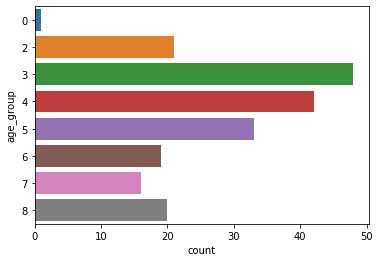

4.0


In [11]:
# Age groups
ax = sns.countplot(y='age_group', data=users_df)
# ax.set_yticklabels([x.name for x in User.AgeGroups])
plt.show()
print(users_df['age_group'].median())

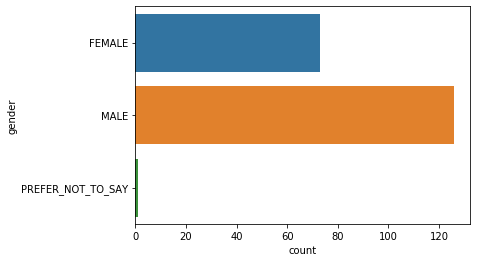

M    126
F     73
U      1
Name: gender, dtype: int64


In [12]:
# Gender
ax = sns.countplot(y='gender', data=users_df)
ax.set_yticklabels([x.name for x in User.Genders])
plt.show()
print(users_df['gender'].value_counts())

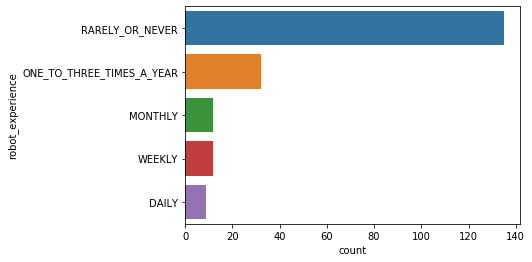

0    135
1     32
3     12
2     12
4      9
Name: robot_experience, dtype: int64


In [13]:
# Robot Experience
ax = sns.countplot(y='robot_experience', data=users_df)
ax.set_yticklabels([x.name for x in User.RobotExperienceGroups])
# ax.legend(labels=[x.name for x in User.StudyConditions])
plt.show()
print(users_df['robot_experience'].value_counts())

## The Survey

Conduct some preliminary analysis of the survey data

In [14]:
# Print the Cronbach's Alpha
_, cronbach_alpha = data_loader.get_survey_df(return_alpha=True)
for k, v in cronbach_alpha.items():
    print(k, f"{v:.3f}")

combo1 0.837
combo3 0.732
combo2 0.724
combo4 0.583
combo5 0.614
combo6 0.507
combo7 0.806
sus 0.940


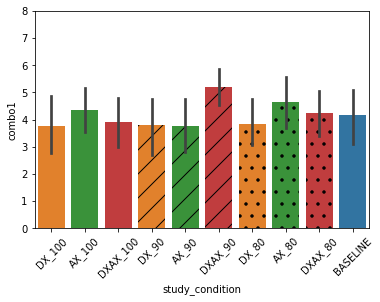



Summary:
                            N  Mean        SD        SE  95% Conf.  Interval  \
has_ax has_dx noise_level                                                      
False  False  0.0          20  4.15  2.412140  0.539371   3.065369  5.234631   
       True   0.0          20  3.75  2.510504  0.561366   2.621140  4.878860   
              1.0          20  3.80  2.483631  0.555357   2.683223  4.916777   
              2.0          20  3.85  2.058998  0.460406   2.924161  4.775839   
True   False  0.0          20  4.35  1.871532  0.418487   3.508457  5.191543   
              1.0          20  3.75  2.244877  0.501970   2.740580  4.759420   
              2.0          20  4.65  2.323224  0.519489   3.605351  5.694649   
       True   0.0          20  3.90  2.149663  0.480679   2.933393  4.866607   
              1.0          20  5.20  1.576138  0.352435   4.491282  5.908718   
              2.0          20  4.25  1.943275  0.434529   3.376197  5.123803   

                           m

In [15]:
# Diagnosis
survey_df = data_loader.get_survey_df()
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 8],
    },
]
out_var = 'combo1'  # diagnosis

# Plot and get significance
plotter.plot_data(survey_df, variables_to_plot, out_var)
o, r = stats.test_significance(survey_df, 'combo1', 'has_ax', 'has_dx', 'noise_level')
print(o)

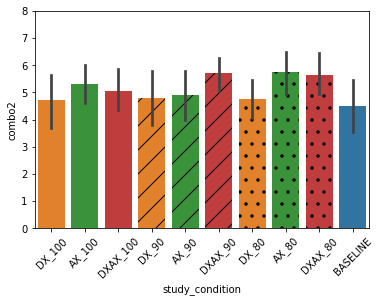



Summary:
                            N  Mean        SD        SE  95% Conf.  Interval  \
has_ax has_dx noise_level                                                      
False  False  0.0          20  4.50  2.115109  0.472953   3.548931  5.451069   
       True   0.0          20  4.70  2.296450  0.513502   3.667390  5.732610   
              1.0          20  4.80  2.375312  0.531136   3.731930  5.868070   
              2.0          20  4.75  1.712954  0.383028   3.979762  5.520238   
True   False  0.0          20  5.30  1.592747  0.356149   4.583814  6.016186   
              1.0          20  4.90  1.997367  0.446625   4.001874  5.798126   
              2.0          20  5.75  1.831738  0.409589   4.926350  6.573650   
       True   0.0          20  5.05  1.791060  0.400493   4.244641  5.855359   
              1.0          20  5.70  1.301821  0.291096   5.114630  6.285370   
              2.0          20  5.65  1.755443  0.392529   4.860657  6.439343   

                           m

In [16]:
# Actions
survey_df = data_loader.get_survey_df()
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 8],
    },
]
out_var = 'combo2'  # actions

# Plot and get the significance
plotter.plot_data(survey_df, variables_to_plot, out_var)
o, r = stats.test_significance(survey_df, 'combo2', 'has_ax', 'has_dx', 'noise_level')
print(o)

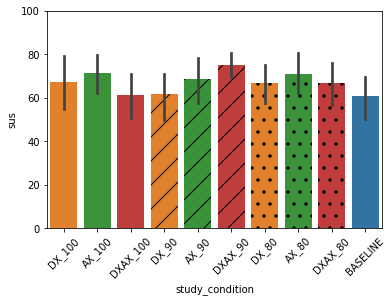



Summary:
                            N    Mean         SD        SE  95% Conf.  \
has_ax has_dx noise_level                                               
False  False  0.0          20  60.875  22.988484  5.140381  50.538117   
       True   0.0          20  67.375  30.429762  6.804302  53.692110   
              1.0          20  61.750  25.040756  5.599283  50.490303   
              2.0          20  66.625  19.806216  4.428804  57.719039   
True   False  0.0          20  71.250  21.282869  4.758994  61.680055   
              1.0          20  68.500  25.188761  5.632378  57.173752   
              2.0          20  71.125  21.251548  4.751991  61.569139   
       True   0.0          20  61.375  24.122426  5.393938  50.528234   
              1.0          20  75.250  14.997807  3.353612  68.506164   
              2.0          20  66.750  22.464885  5.023301  56.648556   

                            Interval  median  
has_ax has_dx noise_level                     
False  False  0.0 

In [17]:
# SUS
survey_df = data_loader.get_survey_df()
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 100],
    },
]
out_var = 'sus'

# Plot and get the significance
plotter.plot_data(survey_df, variables_to_plot, out_var)
o, r = stats.test_significance(survey_df, 'sus', 'has_ax', 'has_dx', 'noise_level')
print(o)

## Scratch

Try out a bunch of things here

In [30]:
# Check this multicollinearity between variables
plot_df = data_loader.get_survey_df()
# plot_df = plot_df.loc[plot_df.study_condition != User.StudyConditions.BASELINE, :]
# plot_df.loc[:, ['has_noise', 'has_dx', 'noise_level', 'has_ax']] = \
#     plot_df.loc[:, ['has_noise', 'has_dx', 'noise_level', 'has_ax']].astype(np.int)
formula = "frac_actions_diff ~ (C(has_ax) + C(has_dx)) * C(noise_level)"
model = smapi.ols(formula, data=plot_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      frac_actions_diff   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     2.337
Date:                Wed, 26 Feb 2020   Prob (F-statistic):             0.0204
Time:                        03:45:03   Log-Likelihood:                -74.260
No. Observations:                 200   AIC:                             166.5
Df Residuals:                     191   BIC:                             196.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [48]:
# Try a different coding scheme, especially for the noise
plot_df = data_loader.get_survey_df()
plot_df = plot_df.loc[plot_df.study_condition != User.StudyConditions.BASELINE, :]
plot_df.loc[plot_df.num_ax_followed.isna(), 'num_ax_followed'] = -2
plot_df['scenario_completed'] = plot_df['scenario_completed'].astype(np.int)
# (frac_ax_optimal + C(scenario_completed))
formula = 'frac_actions_diff ~ ' +\
    "+ (C(has_ax) + C(has_dx))*C(noise_level)" +\
    "+ robot_experience + C(gender, Diff) + C(age_group, Diff) + center(sus) + center(combo1)"
# formula = 'frac_ax_optimal ~ standardize(sus)' +\
#     ' * num_ax_followed * standardize(diagnosis_certainty_mean) * diagnosis_certainty_median'
model = smapi.ols(formula, data=plot_df)
results = model.fit()
print(results.summary())
print(spstats.shapiro(results.resid))

                            OLS Regression Results                            
Dep. Variable:      frac_actions_diff   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     7.013
Date:                Wed, 26 Feb 2020   Prob (F-statistic):           2.55e-13
Time:                        04:04:23   Log-Likelihood:                -20.255
No. Observations:                 180   AIC:                             80.51
Df Residuals:                     160   BIC:                             144.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [20]:
# Try IV Regression?
plot_df = data_loader.get_survey_df()
plot_df.loc[plot_df.num_ax_followed.isna(), 'num_ax_followed'] = -1

# Create an IV transformation
dependent, endog = dmatrices(
    "frac_actions_diff ~ frac_ax_optimal + C(scenario_completed)",
    data=plot_df
)
exog = dmatrix("C(has_ax) + C(has_dx) + C(noise_level) + num_optimal", data=plot_df)
instruments = dmatrix('standardize(sus) * center(num_ax_followed) * center(diagnosis_certainty_mean)' + '',
#                       ' * center(diagnosis_certainty_median)',
                      data=plot_df)

# model = IV2SLS(dependent, exog, endog, instruments)
model = IVGMM(dependent, exog, endog, instruments, weight_type='robust')
results = model.fit()
print(results)

ValueError: regressors [exog endog] do not have full column rank

## The Metrics

The main research question that we're interested in: did people actually benefit from the suggestions?

### Num Actions Diff

The number of actions over and above the optimal number of actions. We normalize by the number of extra actions it is possible to take, given the scenario

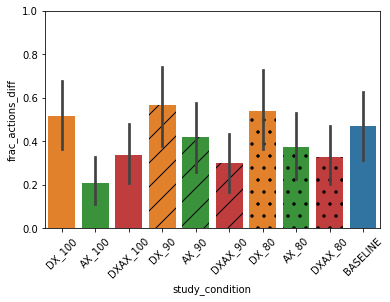

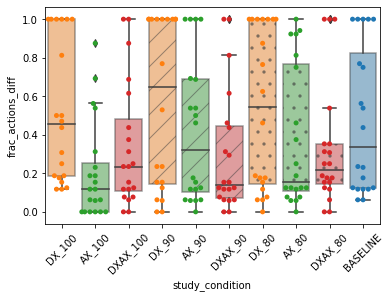

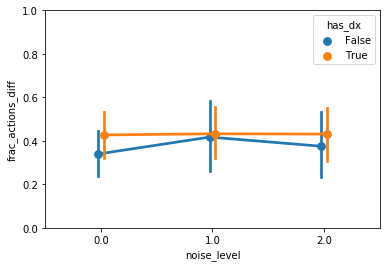

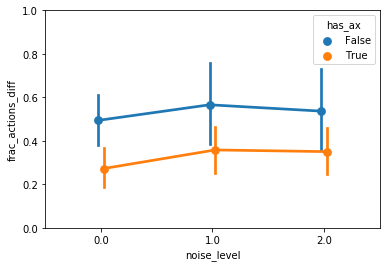

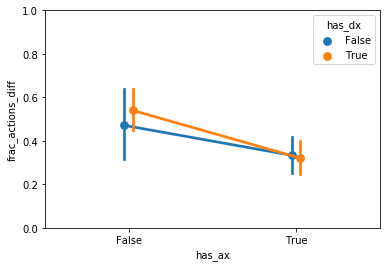



Doing pairwise
All numbers are identical in mannwhitneyu
Summary:
                                               N      Mean        SD  \
has_ax has_dx noise_level scenario_completed                           
False  False  0.0         False                5  1.000000  0.000000   
                          True                15  0.295211  0.248577   
       True   0.0         False                6  1.000000  0.000000   
                          True                14  0.310278  0.205839   
              1.0         False                9  1.000000  0.000000   
                          True                11  0.211204  0.237143   
              2.0         False                7  1.000000  0.000000   
                          True                13  0.287700  0.292503   
True   False  0.0         True                20  0.207975  0.258542   
              1.0         False                4  1.000000  0.000000   
                          True                16  0.271970  0.248222

In [22]:
# All conditions
plot_df = data_loader.get_users_df()

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'rotation': 45,
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
    },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', 'ylim': [0, 1], },
    { 'var': ('noise_level', 'has_ax',), 'type': 'point', 'ylim': [0, 1], },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [0, 1], },
]
out_var = 'frac_actions_diff'

# Plot and test significance of results
plotter.plot_data(plot_df, variables_to_plot, out_var, as_subplots=False)
formulae = (
    'frac_actions_diff ~ C(has_ax) + C(has_dx) + C(noise_level) + C(scenario_completed)',
    'frac_actions_diff ~ C(has_ax) + C(has_dx) + C(noise_level) ' +
    '+ (frac_ax_optimal * C(scenario_completed))',
    'frac_actions_diff ~ C(has_ax) + C(has_dx) + C(noise_level) + (C(start_condition) * C(scenario_completed))',
)
o, r = stats.test_significance(plot_df,
                               'frac_actions_diff',
#                                'study_condition',
                               'has_ax', 'has_dx', 'noise_level',
#                                'has_ax', 'has_noise', 'has_dx',
#                                'start_condition',
                               'scenario_completed', formula=formulae[0],
#                                'scenario_completed', 'frac_ax_optimal', formula=formulae[1],
#                                'scenario_completed', 'start_condition', formula=formulae[2],
                               correction_method='fdr_bh')
print(o)

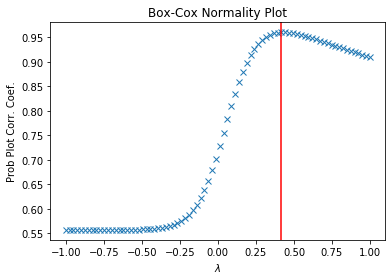

Transformed Y: 0.416, None


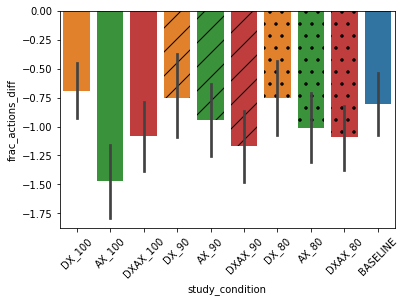

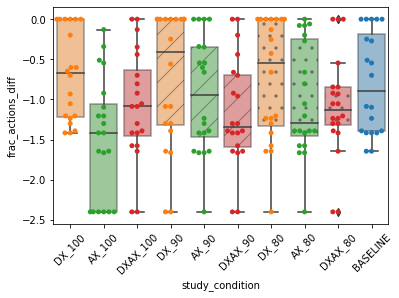

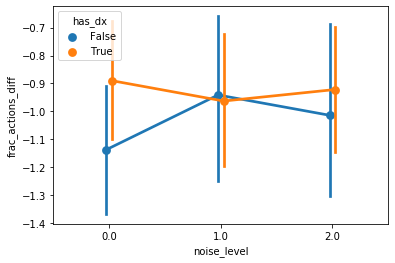

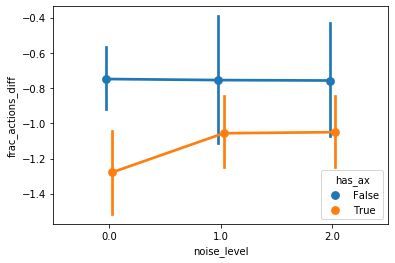

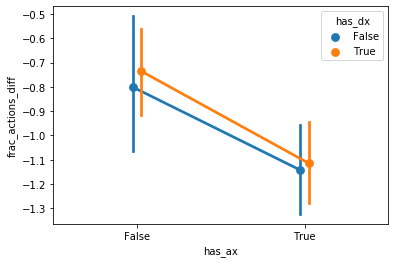



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
1                20 -0.801102  0.631361  0.141177  -1.084996 -0.517207   
2                20 -0.695414  0.564609  0.126250  -0.949293 -0.441534   
3                20 -1.472712  0.752344  0.168229  -1.811007 -1.134417   
4                20 -1.084904  0.692215  0.154784  -1.396162 -0.773646   
5                20 -0.754274  0.848635  0.189761  -1.135867 -0.372681   
6                20 -0.941216  0.718256  0.160607  -1.264183 -0.618249   
7                20 -1.171604  0.686199  0.153439  -1.480156 -0.863051   
8                20 -0.756728  0.764992  0.171057  -1.100711 -0.412746   
9                20 -1.014005  0.697601  0.155988  -1.327685 -0.700325   
10               20 -1.086531  0.653882  0.146212  -1.380552 -0.792510   

                   median  
study_condition            
1               -0.893316  
2               

In [19]:
# All conditions, but with a Box-Cox transformation
plot_df = data_loader.get_users_df()

# Run a box-cox transform
x = plot_df['frac_actions_diff'].to_numpy()+1e-7
fig = plt.figure()
ax = fig.add_subplot(111)
spstats.boxcox_normplot(x, -1, 1, plot=ax)
lmbda = 0.416
if lmbda is None:
    (y, lmbda, ci) = spstats.boxcox(x, alpha=0.05)
else:
    y = spstats.boxcox(x, lmbda=lmbda)
    ci = None
ax.axvline(lmbda, color='r')
plt.show()
print(f'Transformed Y: {lmbda}, {ci}')

plot_df['frac_actions_diff'] = y
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'rotation': 45,
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
    },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', },
    { 'var': ('noise_level', 'has_ax',), 'type': 'point', },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', },
]
out_var = 'frac_actions_diff'

# Plot and test significance of results
plotter.plot_data(plot_df, variables_to_plot, out_var, as_subplots=False)
o, r = stats.test_significance(plot_df,
                               'frac_actions_diff',
                               'study_condition',
#                                'has_ax', 'has_dx', 'noise_level',
#                                'start_condition',
                               correction_method='fdr_bh')
print(o)

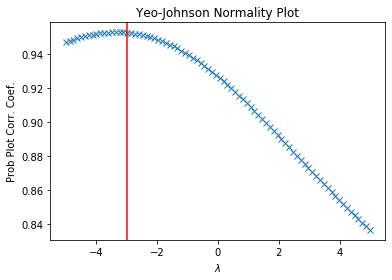

Transformed Y: -3


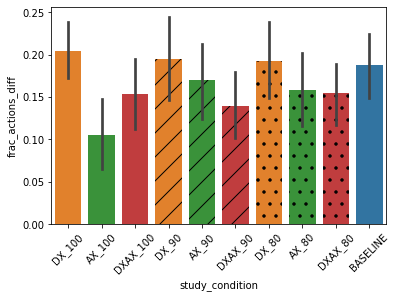

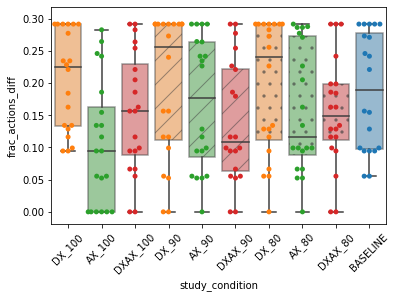

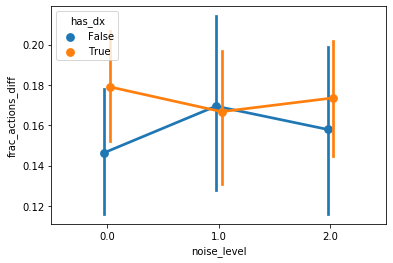

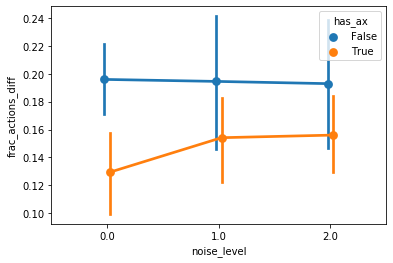

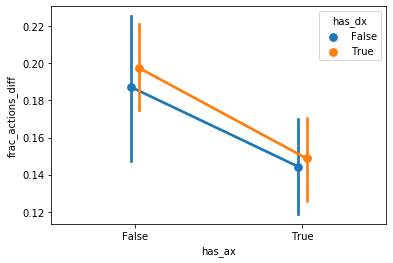



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
1                20  0.187208  0.091181  0.020389   0.146208  0.228208   
2                20  0.204748  0.077581  0.017348   0.169863  0.239633   
3                20  0.105647  0.097470  0.021795   0.061819  0.149475   
4                20  0.153258  0.094256  0.021076   0.110875  0.195641   
5                20  0.194558  0.110639  0.024740   0.144809  0.244308   
6                20  0.169458  0.102182  0.022849   0.123511  0.215405   
7                20  0.138909  0.094808  0.021200   0.096278  0.181540   
8                20  0.192954  0.104130  0.023284   0.146131  0.239777   
9                20  0.157944  0.098430  0.022010   0.113684  0.202203   
10               20  0.154161  0.085484  0.019115   0.115722  0.192599   

                   median  
study_condition            
1                0.188808  
2               

In [20]:
# All conditions, but with a Yeo-Johnson transformation
plot_df = data_loader.get_users_df()

# Run a box-cox transform
x = plot_df['frac_actions_diff'].to_numpy()
fig = plt.figure()
ax = fig.add_subplot(111)
spstats.yeojohnson_normplot(x, -5, 5, plot=ax)
lmbda = -3
if lmbda is not None:
    y = spstats.yeojohnson(x, lmbda=lmbda)
else:
    (y, lmbda) = spstats.yeojohnson(x)
ax.axvline(lmbda, color='r')
plt.show()
print(f'Transformed Y: {lmbda}')

plot_df['frac_actions_diff'] = y
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'rotation': 45,
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
    },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', },
    { 'var': ('noise_level', 'has_ax',), 'type': 'point', },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', },
]
out_var = 'frac_actions_diff'

# Plot and test significance of results
plotter.plot_data(plot_df, variables_to_plot, out_var, as_subplots=False)
o, r = stats.test_significance(plot_df,
                               'frac_actions_diff',
                               'study_condition',
#                                'has_ax', 'has_dx', 'noise_level',
#                                'start_condition',
                               correction_method='fdr_bh')
print(o)

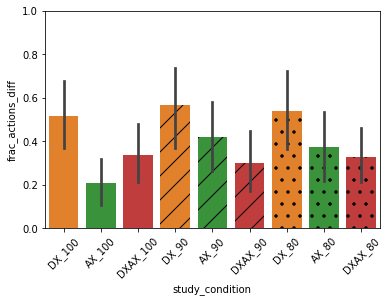

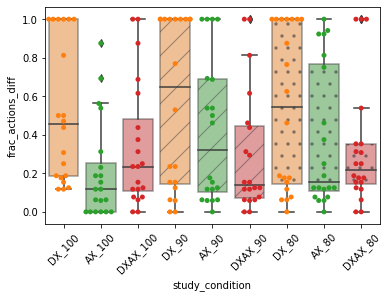

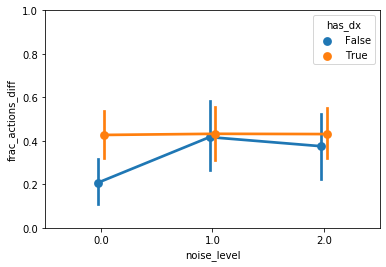

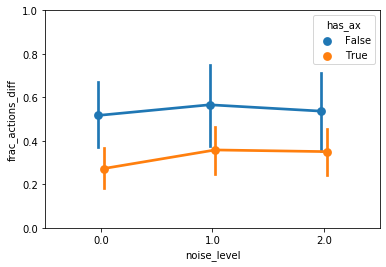

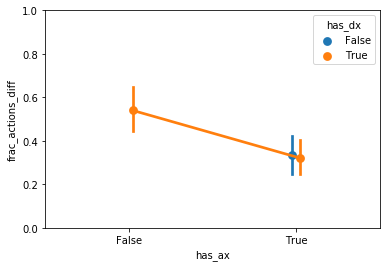



Summary:
                N      Mean        SD        SE  95% Conf.  Interval    median
has_ax has_dx                                                                 
False  True    60  0.540121  0.402336  0.051941   0.437457  0.642785  0.485294
True   False   60  0.333734  0.342451  0.044210   0.246351  0.421117  0.153846
       True    60  0.320984  0.316394  0.040846   0.240250  0.401719  0.181985

                            OLS Regression Results                            
Dep. Variable:      frac_actions_diff   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     7.181
Date:                Tue, 25 Feb 2020   Prob (F-statistic):            0.00100
Time:                        21:35:54   Log-Likelihood:                -67.761
No. Observations:                 180   AIC:                             141.5
Df Residuals:                     177   

In [184]:
# Without baseline 
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[~(plot_df.study_condition == User.StudyConditions.BASELINE), :]
plot_conditions = [x for x in study_conditions if x != User.StudyConditions.BASELINE]

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'rotation': 45,
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
    },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', 'ylim': [0, 1], },
    { 'var': ('noise_level', 'has_ax',), 'type': 'point', 'ylim': [0, 1], },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [0, 1], },
]
out_var = 'frac_actions_diff'

# Plot and test significance of results
plotter.plot_data(plot_df, variables_to_plot, out_var, as_subplots=False)
o, r = stats.test_significance(plot_df,
                               'frac_actions_diff',
#                                'study_condition',
#                                'has_ax', 'has_noise', 'has_dx',
#                                'has_ax', 'has_noise',
#                                'has_ax', 'noise_level',
                               'has_ax', 'has_dx',
                               correction_method='fdr_bh')
print(o)

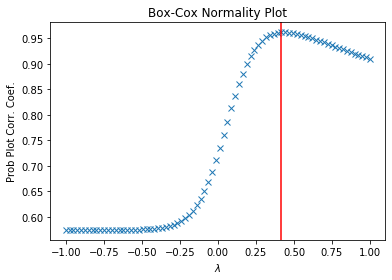

Transformed Y: 0.416, None


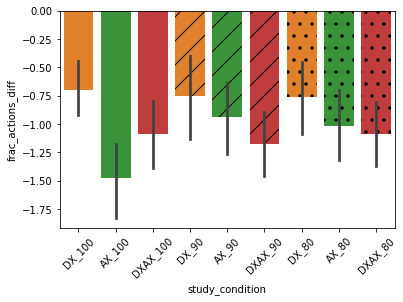

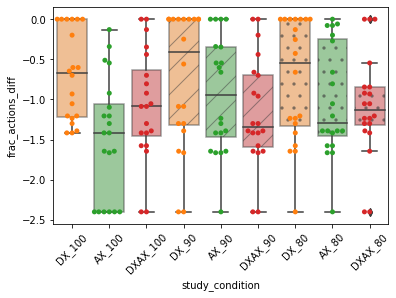

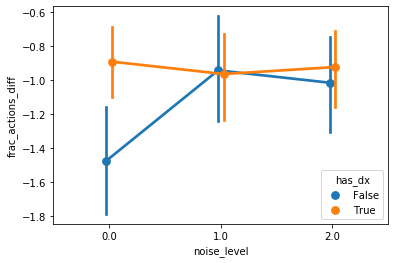

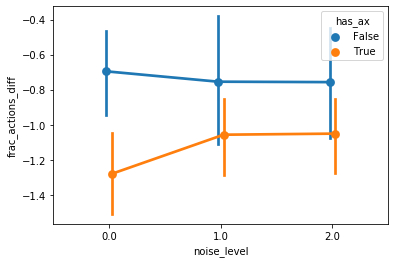

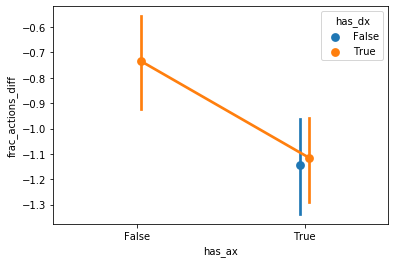



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
2                20 -0.695414  0.564609  0.126250  -0.949293 -0.441534   
3                20 -1.472712  0.752344  0.168229  -1.811007 -1.134417   
4                20 -1.084904  0.692215  0.154784  -1.396162 -0.773646   
5                20 -0.754274  0.848635  0.189761  -1.135867 -0.372681   
6                20 -0.941216  0.718256  0.160607  -1.264183 -0.618249   
7                20 -1.171604  0.686199  0.153439  -1.480156 -0.863051   
8                20 -0.756728  0.764992  0.171057  -1.100711 -0.412746   
9                20 -1.014005  0.697601  0.155988  -1.327685 -0.700325   
10               20 -1.086531  0.653882  0.146212  -1.380552 -0.792510   

                   median  
study_condition            
2               -0.673275  
3               -1.416957  
4               -1.087115  
5               -0.403682  
6     

In [138]:
# Without Baseline, but with a Box-Cox transformation
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[~(plot_df.study_condition == User.StudyConditions.BASELINE), :]
plot_conditions = [x for x in study_conditions if x != User.StudyConditions.BASELINE]

# Run a box-cox transform
x = plot_df['frac_actions_diff'].to_numpy()+1e-7
fig = plt.figure()
ax = fig.add_subplot(111)
spstats.boxcox_normplot(x, -1, 1, plot=ax)
lmbda = 0.416
if lmbda is None:
    (y, lmbda, ci) = spstats.boxcox(x, alpha=0.05)
else:
    y = spstats.boxcox(x, lmbda=lmbda)
    ci = None
ax.axvline(lmbda, color='r')
plt.show()
print(f'Transformed Y: {lmbda}, {ci}')

plot_df['frac_actions_diff'] = y
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'rotation': 45,
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
    },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', },
    { 'var': ('noise_level', 'has_ax',), 'type': 'point', },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', },
]
out_var = 'frac_actions_diff'

# Plot and test significance of results
plotter.plot_data(plot_df, variables_to_plot, out_var, as_subplots=False)
o, r = stats.test_significance(plot_df,
                               'frac_actions_diff',
                               'study_condition',
#                                'has_ax', 'has_dx', 'noise_level',
#                                'start_condition',
                               correction_method='fdr_bh')
print(o)

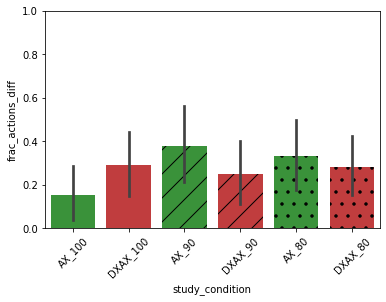

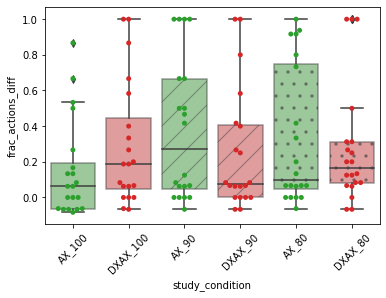

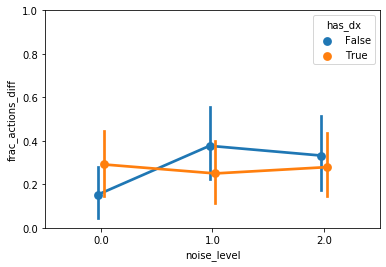



Summary:
                     N      Mean        SD        SE  95% Conf.  Interval  \
has_dx noise_level                                                          
False  0.0          20  0.153333  0.275019  0.061496   0.029670  0.276997   
       1.0          20  0.377500  0.395330  0.088398   0.199738  0.555262   
       2.0          20  0.332708  0.390103  0.087230   0.157296  0.508120   
True   0.0          20  0.291875  0.348840  0.078003   0.135017  0.448733   
       1.0          20  0.250417  0.342806  0.076654   0.096272  0.404561   
       2.0          20  0.279375  0.338578  0.075708   0.127132  0.431618   

                      median  
has_dx noise_level            
False  0.0          0.062500  
       1.0          0.270833  
       2.0          0.100000  
True   0.0          0.187500  
       1.0          0.075000  
       2.0          0.166667  

                            OLS Regression Results                            
Dep. Variable:      frac_actions_diff   R-sq

In [20]:
# Let's assume that we have to have action suggestions... Should we add diagnoses? 
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df.has_ax, :]
plot_conditions = [x for x in study_conditions if x in User.SHOW_AX_STUDY_CONDITIONS]

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'rotation': 45,
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
    },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', 'ylim': [0, 1], },
]
out_var = 'frac_actions_diff'

# Plot and test significance of results
plotter.plot_data(plot_df, variables_to_plot, out_var, as_subplots=False)
o, r = stats.test_significance(plot_df,
                               'frac_actions_diff',
                               'has_dx', 'noise_level',
                               correction_method='fdr_bh')
print(o)

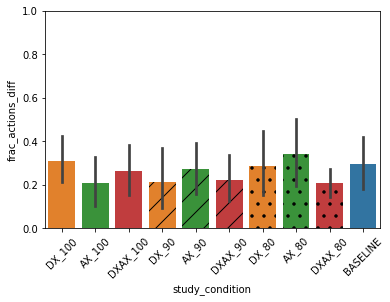

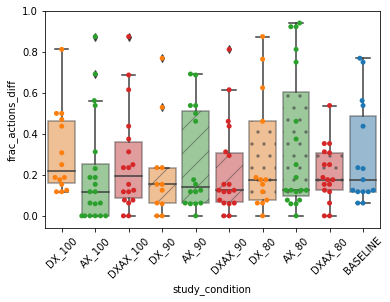

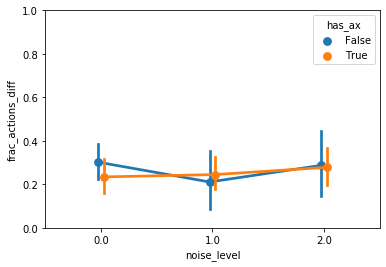



Summary:
                          N      Mean        SD        SE  95% Conf.  \
has_ax has_dx has_noise                                                
False  False  False      15  0.295211  0.248577  0.064182   0.164998   
       True   False      14  0.310278  0.205839  0.055013   0.198383   
              True       24  0.252640  0.265717  0.054239   0.144044   
True   False  False      20  0.207975  0.258542  0.057812   0.091720   
              True       35  0.310415  0.301671  0.050992   0.209012   
       True   False      18  0.264109  0.248175  0.058495   0.146134   
              True       35  0.214431  0.185989  0.031438   0.151913   

                         Interval    median  
has_ax has_dx has_noise                      
False  False  False      0.425424  0.176471  
       True   False      0.422173  0.218750  
              True       0.361235  0.153846  
True   False  False      0.324230  0.117647  
              True       0.411818  0.125000  
       True   Fals

In [24]:
# Let's assume that we remove anyone that couldn't figure out how to complete the task 
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df.scenario_completed, :]

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'rotation': 45,
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
    },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 1], },
]
out_var = 'frac_actions_diff'

# Plot and test significance of results
plotter.plot_data(plot_df, variables_to_plot, out_var, as_subplots=False)
o, r = stats.test_significance(plot_df,
                               'frac_actions_diff',
                               'has_ax', 'has_dx', 'has_noise',
                               correction_method='fdr_bh')
print(o)

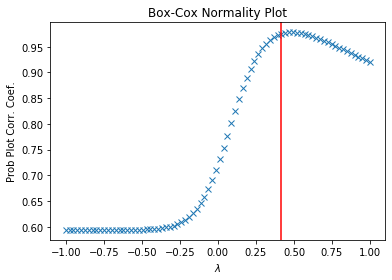

Transformed Y: 0.416, None


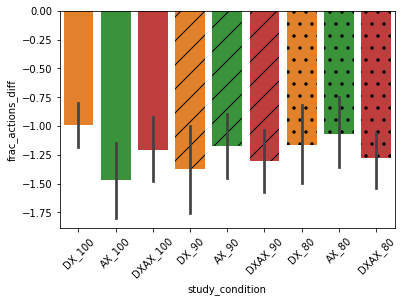

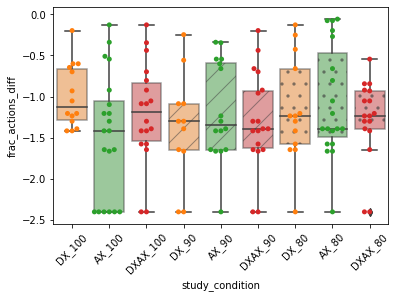

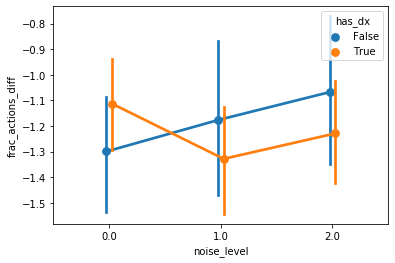

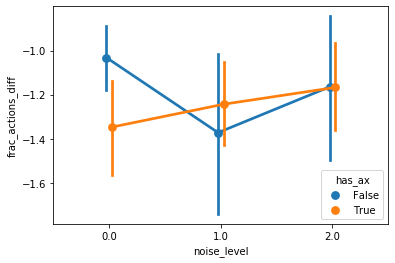

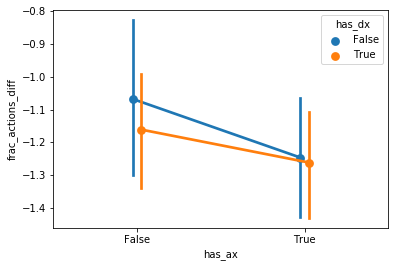



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
1                15 -1.068136  0.485157  0.125267  -1.322277 -0.813995   
2                14 -0.993448  0.383480  0.102489  -1.201910 -0.784986   
3                20 -1.472712  0.752344  0.168229  -1.811007 -1.134417   
4                18 -1.205449  0.617798  0.145616  -1.499132 -0.911766   
5                11 -1.371408  0.661338  0.199401  -1.781310 -0.961506   
6                16 -1.176520  0.598471  0.149618  -1.479388 -0.873652   
7                18 -1.301782  0.588925  0.138811  -1.581739 -1.021825   
8                13 -1.164198  0.642402  0.178170  -1.527671 -0.800724   
9                19 -1.067374  0.673464  0.154503  -1.378498 -0.756249   
10               17 -1.278272  0.497306  0.120614  -1.521952 -1.034592   

                   median  
study_condition            
1               -1.235632  
2               

In [141]:
# Let's assume that we remove anyone that couldn't figure out how to complete the task & then
# we take a Box-Cox transformation
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df.scenario_completed, :]
plot_conditions = [x for x in study_conditions if x != User.StudyConditions.BASELINE]

# Run a box-cox transform
x = plot_df['frac_actions_diff'].to_numpy()+1e-7
fig = plt.figure()
ax = fig.add_subplot(111)
spstats.boxcox_normplot(x, -1, 1, plot=ax)
lmbda = 0.416
if lmbda is None:
    (y, lmbda, ci) = spstats.boxcox(x, alpha=0.05)
else:
    y = spstats.boxcox(x, lmbda=lmbda)
    ci = None
ax.axvline(lmbda, color='r')
plt.show()
print(f'Transformed Y: {lmbda}, {ci}')

plot_df['frac_actions_diff'] = y
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'rotation': 45,
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
    },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', },
    { 'var': ('noise_level', 'has_ax',), 'type': 'point', },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', },
]
out_var = 'frac_actions_diff'

# Plot and test significance of results
plotter.plot_data(plot_df, variables_to_plot, out_var, as_subplots=False)
o, r = stats.test_significance(plot_df,
                               'frac_actions_diff',
                               'study_condition',
#                                'has_ax', 'has_dx', 'noise_level',
#                                'start_condition',
                               correction_method='fdr_bh')
print(o)

### Scenario Completed

A deeper dive into differentiating the number of people that didn't finish from those that did

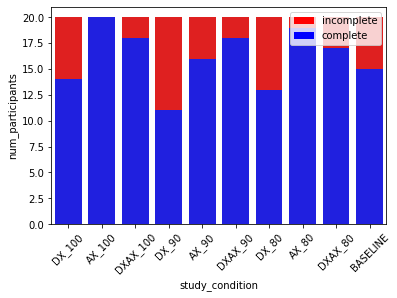

Chi^2(9): 23.2202580028667, p: 0.005720148629698653

Post-hoc BASELINE-DX_100: 0.000(1), 1.000
Post-hoc BASELINE-AX_100: 3.657(1), 0.056
Post-hoc BASELINE-DXAX_100: 0.693(1), 0.405
Post-hoc BASELINE-DX_90: 0.989(1), 0.320
Post-hoc BASELINE-AX_90: 0.000(1), 1.000
Post-hoc BASELINE-DXAX_90: 0.693(1), 0.405
Post-hoc BASELINE-DX_80: 0.119(1), 0.730
Post-hoc BASELINE-AX_80: 1.765(1), 0.184
Post-hoc BASELINE-DXAX_80: 0.156(1), 0.693
Post-hoc DX_100-AX_100: 4.902(1), 0.027
Post-hoc DX_100-DXAX_100: 1.406(1), 0.236
Post-hoc DX_100-DX_90: 0.427(1), 0.514
Post-hoc DX_100-AX_90: 0.133(1), 0.715
Post-hoc DX_100-DXAX_90: 1.406(1), 0.236
Post-hoc DX_100-DX_80: 0.000(1), 1.000
Post-hoc DX_100-AX_80: 2.771(1), 0.096
Post-hoc DX_100-DXAX_80: 0.573(1), 0.449
Post-hoc AX_100-DXAX_100: 0.526(1), 0.468
Post-hoc AX_100-DX_90: 9.176(1), 0.002
Post-hoc AX_100-AX_90: 2.500(1), 0.114
Post-hoc AX_100-DXAX_90: 0.526(1), 0.468
Post-hoc AX_100-DX_80: 6.234(1), 0.013
Post-hoc AX_100-AX_80: 0.000(1), 1.000
Post-hoc A

In [22]:
# All conditions (by conditions)
plot_df = data_loader.get_users_df()
plot_df = pd.crosstab(index=plot_df['study_condition'],
                      columns=plot_df['scenario_completed'].apply(lambda x: 'complete' if x else 'incomplete'))
plot_df = plot_df.reset_index()
plot_df['total'] = plot_df['complete'] + plot_df['incomplete']

# Plot the data
ax = sns.barplot(x='study_condition', y='total', color='red',
                 data=plot_df,
                 order=study_conditions)
ax = sns.barplot(x='study_condition', y='complete', color='blue',
                 data=plot_df,
                 order=study_conditions)
ax.set_xticklabels([x.name for x in study_conditions])
ax.set_ylabel('num_participants')
plt.legend([plt.Rectangle((0,0),1,1,fc="red"), plt.Rectangle((0,0),1,1,fc="blue")],
           ['incomplete', 'complete'])
plt.xticks(rotation=45)
plt.show()

# Conduct a chisq test
plot_df['study_condition'] = plot_df['study_condition'].apply(lambda x: User.StudyConditions(x).name)
plot_df = plot_df.set_index('study_condition')
o, r = stats.test_using_chi2(plot_df.loc[:, ['complete', 'incomplete']])
print(o)

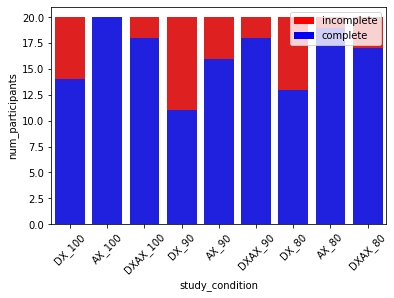

Chi^2(8): 23.352135374697827, p: 0.0029403749651678054

Post-hoc DX_100-AX_100: 4.902(1), 0.027
Post-hoc DX_100-DXAX_100: 1.406(1), 0.236
Post-hoc DX_100-DX_90: 0.427(1), 0.514
Post-hoc DX_100-AX_90: 0.133(1), 0.715
Post-hoc DX_100-DXAX_90: 1.406(1), 0.236
Post-hoc DX_100-DX_80: 0.000(1), 1.000
Post-hoc DX_100-AX_80: 2.771(1), 0.096
Post-hoc DX_100-DXAX_80: 0.573(1), 0.449
Post-hoc AX_100-DXAX_100: 0.526(1), 0.468
Post-hoc AX_100-DX_90: 9.176(1), 0.002
Post-hoc AX_100-AX_90: 2.500(1), 0.114
Post-hoc AX_100-DXAX_90: 0.526(1), 0.468
Post-hoc AX_100-DX_80: 6.234(1), 0.013
Post-hoc AX_100-AX_80: 0.000(1), 1.000
Post-hoc AX_100-DXAX_80: 1.441(1), 0.230
Post-hoc DXAX_100-DX_90: 4.514(1), 0.034
Post-hoc DXAX_100-AX_90: 0.196(1), 0.658
Post-hoc DXAX_100-DXAX_90: 0.000(1), 1.000
Post-hoc DXAX_100-DX_80: 2.294(1), 0.130
Post-hoc DXAX_100-AX_80: 0.000(1), 1.000
Post-hoc DXAX_100-DXAX_80: 0.000(1), 1.000
Post-hoc DX_90-AX_90: 1.823(1), 0.177
Post-hoc DX_90-DXAX_90: 4.514(1), 0.034
Post-hoc DX_90-D

In [102]:
# Remove the baseline
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df['study_condition'] != User.StudyConditions.BASELINE, :]
plot_df = pd.crosstab(index=plot_df['study_condition'],
                      columns=plot_df['scenario_completed'].apply(lambda x: 'complete' if x else 'incomplete'))
plot_df = plot_df.reset_index()
plot_df['total'] = plot_df['complete'] + plot_df['incomplete']
plot_conditions = [x for x in study_conditions if x != User.StudyConditions.BASELINE]

# Plot the data
ax = sns.barplot(x='study_condition', y='total', color='red',
                 data=plot_df,
                 order=plot_conditions)
ax = sns.barplot(x='study_condition', y='complete', color='blue',
                 data=plot_df,
                 order=plot_conditions)
ax.set_xticklabels([x.name for x in plot_conditions])
ax.set_ylabel('num_participants')
plt.legend([plt.Rectangle((0,0),1,1,fc="red"), plt.Rectangle((0,0),1,1,fc="blue")],
           ['incomplete', 'complete'])
plt.xticks(rotation=45)
plt.show()

# Conduct a chisq test
plot_df['study_condition'] = plot_df['study_condition'].apply(lambda x: User.StudyConditions(x).name)
plot_df = plot_df.set_index('study_condition')
o, r = stats.test_using_chi2(plot_df.loc[:, ['complete', 'incomplete']])
print(o)

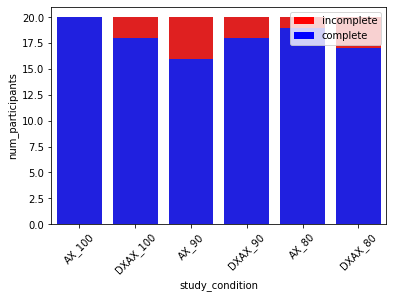

Chi^2(5): 5.555555555555555, p: 0.3518924629819186

Post-hoc AX_100-DXAX_100: 0.526(1), 0.468
Post-hoc AX_100-AX_90: 2.500(1), 0.114
Post-hoc AX_100-DXAX_90: 0.526(1), 0.468
Post-hoc AX_100-AX_80: 0.000(1), 1.000
Post-hoc AX_100-DXAX_80: 1.441(1), 0.230
Post-hoc DXAX_100-AX_90: 0.196(1), 0.658
Post-hoc DXAX_100-DXAX_90: 0.000(1), 1.000
Post-hoc DXAX_100-AX_80: 0.000(1), 1.000
Post-hoc DXAX_100-DXAX_80: 0.000(1), 1.000
Post-hoc AX_90-DXAX_90: 0.196(1), 0.658
Post-hoc AX_90-AX_80: 0.914(1), 0.339
Post-hoc AX_90-DXAX_80: 0.000(1), 1.000
Post-hoc DXAX_90-AX_80: 0.000(1), 1.000
Post-hoc DXAX_90-DXAX_80: 0.000(1), 1.000
Post-hoc AX_80-DXAX_80: 0.278(1), 0.598



In [147]:
# Test the AX conditions
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df['has_ax'], :]
plot_df = pd.crosstab(index=plot_df['study_condition'],
                      columns=plot_df['scenario_completed'].apply(lambda x: 'complete' if x else 'incomplete'))
plot_df = plot_df.reset_index()
plot_df['total'] = plot_df['complete'] + plot_df['incomplete']
plot_conditions = [x for x in study_conditions if x in User.SHOW_AX_STUDY_CONDITIONS]

# Plot the data
ax = sns.barplot(x='study_condition', y='total', color='red',
                 data=plot_df,
                 order=plot_conditions)
ax = sns.barplot(x='study_condition', y='complete', color='blue',
                 data=plot_df,
                 order=plot_conditions)
ax.set_xticklabels([x.name for x in plot_conditions])
ax.set_ylabel('num_participants')
plt.legend([plt.Rectangle((0,0),1,1,fc="red"), plt.Rectangle((0,0),1,1,fc="blue")],
           ['incomplete', 'complete'])
plt.xticks(rotation=45)
plt.show()

# Conduct a chisq test
plot_df['study_condition'] = plot_df['study_condition'].apply(lambda x: User.StudyConditions(x).name)
plot_df = plot_df.set_index('study_condition')
o, r = stats.test_using_chi2(plot_df.loc[:, ['complete', 'incomplete']])
print(o)

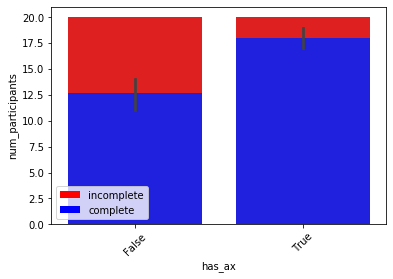

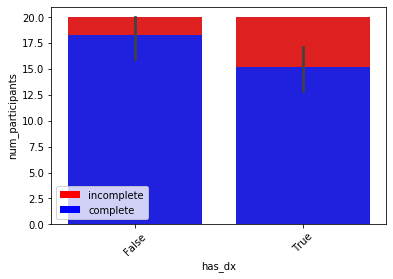

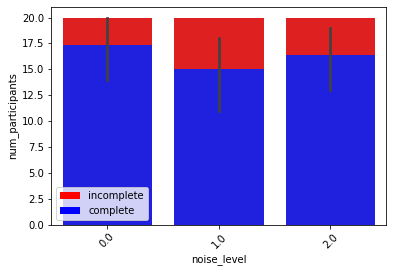

Chi^2(8): 23.352135374697827, p: 0.0029403749651678054

Post-hoc (False, True, 0.0)-(False, True, 1.0): 0.427(1), 0.514
Post-hoc (False, True, 0.0)-(False, True, 2.0): 0.000(1), 1.000
Post-hoc (False, True, 0.0)-(True, False, 0.0): 4.902(1), 0.027
Post-hoc (False, True, 0.0)-(True, True, 0.0): 1.406(1), 0.236
Post-hoc (False, True, 0.0)-(True, False, 1.0): 0.133(1), 0.715
Post-hoc (False, True, 0.0)-(True, True, 1.0): 1.406(1), 0.236
Post-hoc (False, True, 0.0)-(True, False, 2.0): 2.771(1), 0.096
Post-hoc (False, True, 0.0)-(True, True, 2.0): 0.573(1), 0.449
Post-hoc (False, True, 1.0)-(False, True, 2.0): 0.104(1), 0.747
Post-hoc (False, True, 1.0)-(True, False, 0.0): 9.176(1), 0.002
Post-hoc (False, True, 1.0)-(True, True, 0.0): 4.514(1), 0.034
Post-hoc (False, True, 1.0)-(True, False, 1.0): 1.823(1), 0.177
Post-hoc (False, True, 1.0)-(True, True, 1.0): 4.514(1), 0.034
Post-hoc (False, True, 1.0)-(True, False, 2.0): 6.533(1), 0.011
Post-hoc (False, True, 1.0)-(True, True, 2.0): 2.976(

In [152]:
# Reindex based on the individual factors
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df['study_condition'] != User.StudyConditions.BASELINE, :]
plot_df = pd.crosstab(index=[plot_df['has_ax'], plot_df['noise_level'], plot_df['has_dx']],
                      columns=plot_df['scenario_completed'].apply(lambda x: 'complete' if x else 'incomplete'))
plot_df = plot_df.reset_index()
plot_df['total'] = plot_df['complete'] + plot_df['incomplete']
# plot_conditions = [x for x in study_conditions if x != User.StudyConditions.BASELINE]

# Plot the data
ax = sns.barplot(x='has_ax', y='total', color='red',
                 data=plot_df)
ax = sns.barplot(x='has_ax', y='complete', color='blue',
                 data=plot_df)
ax.set_ylabel('num_participants')
plt.legend([plt.Rectangle((0,0),1,1,fc="red"), plt.Rectangle((0,0),1,1,fc="blue")],
           ['incomplete', 'complete'])
plt.xticks(rotation=45)
plt.show()

ax = sns.barplot(x='has_dx', y='total', color='red',
                 data=plot_df)
ax = sns.barplot(x='has_dx', y='complete', color='blue',
                 data=plot_df)
ax.set_ylabel('num_participants')
plt.legend([plt.Rectangle((0,0),1,1,fc="red"), plt.Rectangle((0,0),1,1,fc="blue")],
           ['incomplete', 'complete'])
plt.xticks(rotation=45)
plt.show()

ax = sns.barplot(x='noise_level', y='total', color='red',
                 data=plot_df)
ax = sns.barplot(x='noise_level', y='complete', color='blue',
                 data=plot_df)
ax.set_ylabel('num_participants')
plt.legend([plt.Rectangle((0,0),1,1,fc="red"), plt.Rectangle((0,0),1,1,fc="blue")],
           ['incomplete', 'complete'])
plt.xticks(rotation=45)
plt.show()

# # Conduct a chisq test
plot_df = plot_df.set_index(['has_ax', 'has_dx', 'noise_level'])
o, r = stats.test_using_chi2(plot_df.loc[:, ['complete', 'incomplete']])
print(o)

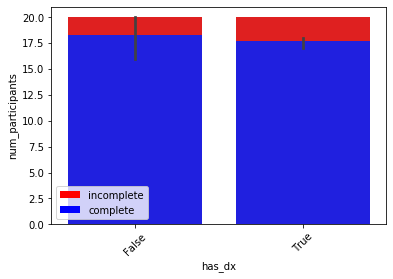

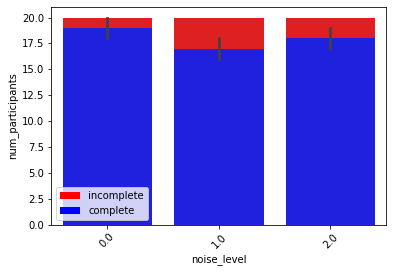

Chi^2(5): 5.555555555555555, p: 0.3518924629819186

Post-hoc (False, 0.0)-(True, 0.0): 0.526(1), 0.468
Post-hoc (False, 0.0)-(False, 1.0): 2.500(1), 0.114
Post-hoc (False, 0.0)-(True, 1.0): 0.526(1), 0.468
Post-hoc (False, 0.0)-(False, 2.0): 0.000(1), 1.000
Post-hoc (False, 0.0)-(True, 2.0): 1.441(1), 0.230
Post-hoc (True, 0.0)-(False, 1.0): 0.196(1), 0.658
Post-hoc (True, 0.0)-(True, 1.0): 0.000(1), 1.000
Post-hoc (True, 0.0)-(False, 2.0): 0.000(1), 1.000
Post-hoc (True, 0.0)-(True, 2.0): 0.000(1), 1.000
Post-hoc (False, 1.0)-(True, 1.0): 0.196(1), 0.658
Post-hoc (False, 1.0)-(False, 2.0): 0.914(1), 0.339
Post-hoc (False, 1.0)-(True, 2.0): 0.000(1), 1.000
Post-hoc (True, 1.0)-(False, 2.0): 0.000(1), 1.000
Post-hoc (True, 1.0)-(True, 2.0): 0.000(1), 1.000
Post-hoc (False, 2.0)-(True, 2.0): 0.278(1), 0.598



In [153]:
# What's the effect of noise and dx on action suggestions?
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df['has_ax'], :]
plot_df = pd.crosstab(index=[plot_df['noise_level'], plot_df['has_dx']],
                      columns=plot_df['scenario_completed'].apply(lambda x: 'complete' if x else 'incomplete'))
plot_df = plot_df.reset_index()
plot_df['total'] = plot_df['complete'] + plot_df['incomplete']
# plot_conditions = [x for x in study_conditions if x != User.StudyConditions.BASELINE]

# Plot the data
ax = sns.barplot(x='has_dx', y='total', color='red',
                 data=plot_df)
ax = sns.barplot(x='has_dx', y='complete', color='blue',
                 data=plot_df)
ax.set_ylabel('num_participants')
plt.legend([plt.Rectangle((0,0),1,1,fc="red"), plt.Rectangle((0,0),1,1,fc="blue")],
           ['incomplete', 'complete'])
plt.xticks(rotation=45)
plt.show()

ax = sns.barplot(x='noise_level', y='total', color='red',
                 data=plot_df)
ax = sns.barplot(x='noise_level', y='complete', color='blue',
                 data=plot_df)
ax.set_ylabel('num_participants')
plt.legend([plt.Rectangle((0,0),1,1,fc="red"), plt.Rectangle((0,0),1,1,fc="blue")],
           ['incomplete', 'complete'])
plt.xticks(rotation=45)
plt.show()

# # Conduct a chisq test
plot_df = plot_df.set_index(['has_dx', 'noise_level'])
o, r = stats.test_using_chi2(plot_df.loc[:, ['complete', 'incomplete']])
print(o)

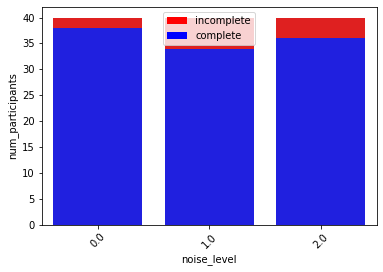

Chi^2(2): 2.2222222222222223, p: 0.3291929878079054

Post-hoc 0.0-1.0: 1.250(1), 0.264
Post-hoc 0.0-2.0: 0.180(1), 0.671
Post-hoc 1.0-2.0: 0.114(1), 0.735



In [154]:
# Vary only 1 independent variable for a given level of another
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df['has_ax'], :]
plot_df = pd.crosstab(index=[plot_df['noise_level'],],
                      columns=plot_df['scenario_completed'].apply(lambda x: 'complete' if x else 'incomplete'))
plot_df = plot_df.reset_index()
plot_df['total'] = plot_df['complete'] + plot_df['incomplete']
# plot_conditions = [x for x in study_conditions if x != User.StudyConditions.BASELINE]

# Plot the data
ax = sns.barplot(x='noise_level', y='total', color='red',
                 data=plot_df)
ax = sns.barplot(x='noise_level', y='complete', color='blue',
                 data=plot_df)
ax.set_ylabel('num_participants')
plt.legend([plt.Rectangle((0,0),1,1,fc="red"), plt.Rectangle((0,0),1,1,fc="blue")],
           ['incomplete', 'complete'])
plt.xticks(rotation=45)
plt.show()

# # Conduct a chisq test
plot_df = plot_df.set_index(['noise_level'])
o, r = stats.test_using_chi2(plot_df.loc[:, ['complete', 'incomplete']])
print(o)

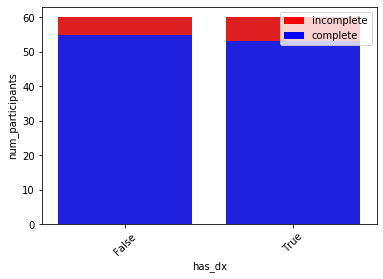

Chi^2(1): 0.09259259259259259, p: 0.7609067270751142

Post-hoc False-True: 0.093(1), 0.761



In [155]:
# Vary only 1 independent variable for a given level of another
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df['has_ax'], :]
plot_df = pd.crosstab(index=[plot_df['has_dx'],],
                      columns=plot_df['scenario_completed'].apply(lambda x: 'complete' if x else 'incomplete'))
plot_df = plot_df.reset_index()
plot_df['total'] = plot_df['complete'] + plot_df['incomplete']
# plot_conditions = [x for x in study_conditions if x != User.StudyConditions.BASELINE]

# Plot the data
ax = sns.barplot(x='has_dx', y='total', color='red',
                 data=plot_df)
ax = sns.barplot(x='has_dx', y='complete', color='blue',
                 data=plot_df)
ax.set_ylabel('num_participants')
plt.legend([plt.Rectangle((0,0),1,1,fc="red"), plt.Rectangle((0,0),1,1,fc="blue")],
           ['incomplete', 'complete'])
plt.xticks(rotation=45)
plt.show()

# # Conduct a chisq test
plot_df = plot_df.set_index(['has_dx'])
o, r = stats.test_using_chi2(plot_df.loc[:, ['complete', 'incomplete']])
print(o)

### Optimal Actions

Was the participant taking optimal actions? We can also check here if they were taking wrong actions.

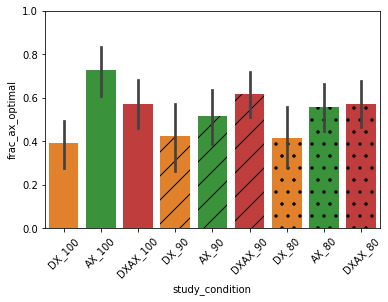

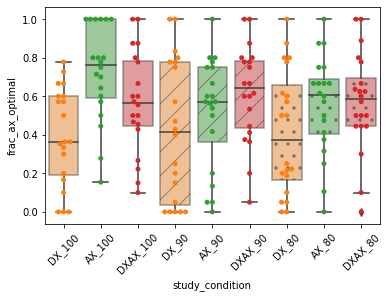

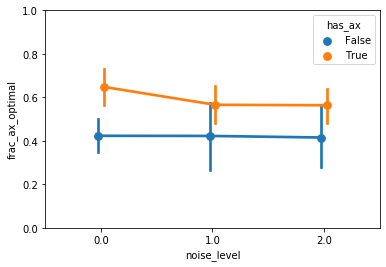

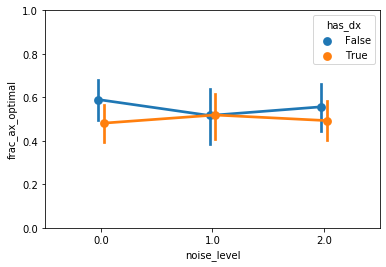

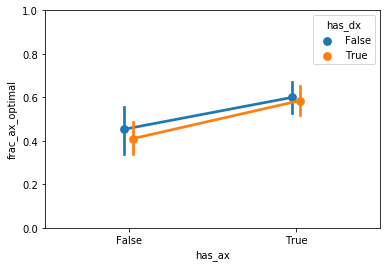



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
1                20  0.454067  0.262811  0.058766   0.335893  0.572241   
2                20  0.393073  0.253773  0.056745   0.278963  0.507183   
3                20  0.726621  0.248812  0.055636   0.614741  0.838500   
4                20  0.570505  0.264311  0.059102   0.451657  0.689354   
5                20  0.422974  0.366192  0.081883   0.258314  0.587634   
6                20  0.516913  0.288024  0.064404   0.387402  0.646424   
7                20  0.615373  0.251187  0.056167   0.502425  0.728320   
8                20  0.415680  0.325087  0.072692   0.269503  0.561857   
9                20  0.556749  0.257286  0.057531   0.441059  0.672439   
10               20  0.571223  0.258429  0.057786   0.455019  0.687427   

                   median  
study_condition            
1                0.485294  
2               

In [28]:
# The number of times the best action was taken was selected (all conditions)
plot_df = data_loader.get_users_df()
plot_conditions = study_conditions

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 1] },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', 'ylim': [0, 1] },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [0, 1] },
]
out_var = 'frac_ax_optimal'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of number of actions that were deemed optimal for the state
o, r = stats.test_significance(plot_df,
                               'frac_ax_optimal',
                               'study_condition',
#                                'has_dx', 'has_noise',
                               correction_method='fdr_bh')
print(o)

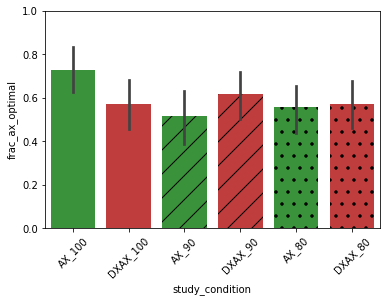

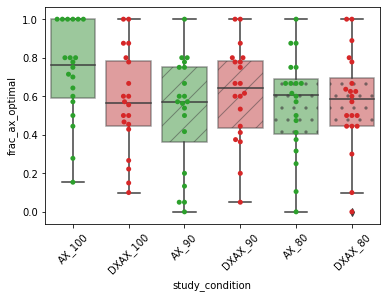

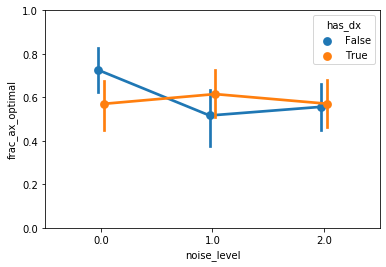



Summary:
                     N      Mean        SD        SE  95% Conf.  Interval  \
has_dx noise_level                                                          
False  0.0          20  0.726621  0.248812  0.055636   0.614741  0.838500   
       1.0          20  0.516913  0.288024  0.064404   0.387402  0.646424   
       2.0          20  0.556749  0.257286  0.057531   0.441059  0.672439   
True   0.0          20  0.570505  0.264311  0.059102   0.451657  0.689354   
       1.0          20  0.615373  0.251187  0.056167   0.502425  0.728320   
       2.0          20  0.571223  0.258429  0.057786   0.455019  0.687427   

                      median  
has_dx noise_level            
False  0.0          0.763889  
       1.0          0.571429  
       2.0          0.607692  
True   0.0          0.563492  
       1.0          0.641026  
       2.0          0.585714  

                            OLS Regression Results                            
Dep. Variable:        frac_ax_optimal   R-sq

In [31]:
# The number of times the best action was taken was selected, but focus on when we provided suggestions
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df['has_ax'],:]
plot_conditions = [x for x in study_conditions if 'AX' in x.name]

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', 'ylim': [0, 1] },
]
out_var = 'frac_ax_optimal'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of number of actions that were deemed optimal for the state
o, r = stats.test_significance(plot_df,
                               'frac_ax_optimal',
#                                'study_condition',
                               'has_dx', 'noise_level',
                               correction_method='fdr_bh')
print(o)

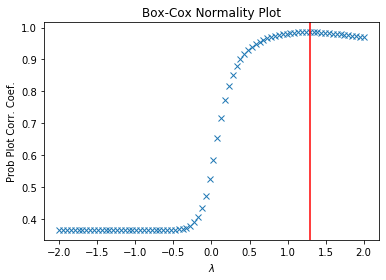

Transformed Y: 1.3, None


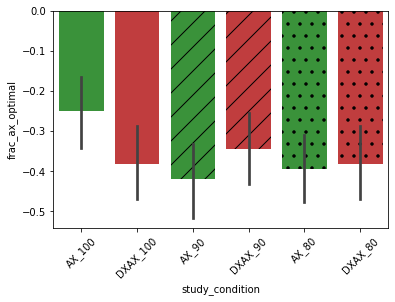

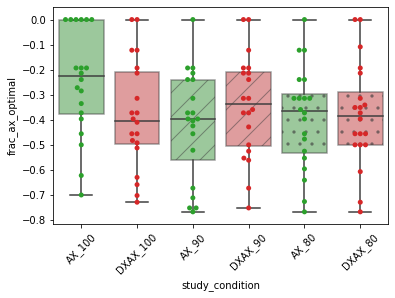

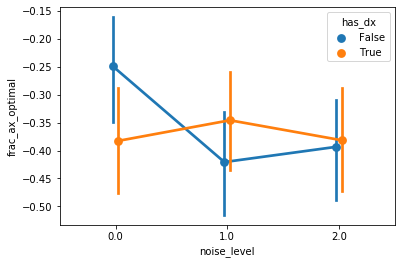

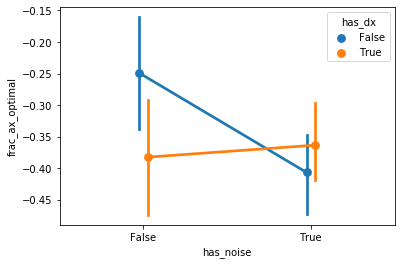



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
3                20 -0.249194  0.215411  0.048167  -0.346055 -0.152334   
4                20 -0.382689  0.219055  0.048982  -0.481189 -0.284190   
6                20 -0.420625  0.218795  0.048924  -0.519007 -0.322243   
7                20 -0.345884  0.206869  0.046257  -0.438904 -0.252865   
9                20 -0.393463  0.203407  0.045483  -0.484926 -0.302000   
10               20 -0.381541  0.207777  0.046460  -0.474969 -0.288113   

                   median  
study_condition            
3               -0.227200  
4               -0.404286  
6               -0.397604  
7               -0.337582  
9               -0.366644  
10              -0.385436  

                            OLS Regression Results                            
Dep. Variable:        frac_ax_optimal   R-squared:                       0.066
Model:       

In [59]:
# The number of times the best action was taken was selected, but focus on when we provided suggestions
# Use a boxcox transformation this time
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df['has_ax'],:]
plot_conditions = [x for x in study_conditions if 'AX' in x.name]

# Run a box-cox transform
x = plot_df['frac_ax_optimal'].to_numpy()+1e-7
fig = plt.figure()
ax = fig.add_subplot(111)
spstats.boxcox_normplot(x, -2, 2, plot=ax)
lmbda = 1.3
if lmbda is None:
    (y, lmbda, ci) = spstats.boxcox(x, alpha=0.05)
else:
    y = spstats.boxcox(x, lmbda=lmbda)
    ci = None
ax.axvline(lmbda, color='r')
plt.show()
print(f'Transformed Y: {lmbda}, {ci}')

plot_df['frac_ax_optimal'] = y
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', },
    { 'var': ('has_noise', 'has_dx'), 'type': 'point', },
]
out_var = 'frac_ax_optimal'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of number of actions that were deemed optimal for the state
o, r = stats.test_significance(plot_df,
                               'frac_ax_optimal',
                               'study_condition',
#                                'has_dx', 'noise_level',
#                                'has_dx', 'has_noise',
                               correction_method='fdr_bh')
print(o)

### Action Suggestions Followed

Did people follow suggestions when they were present? What if they were corrupted?

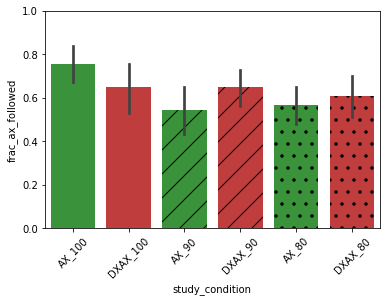

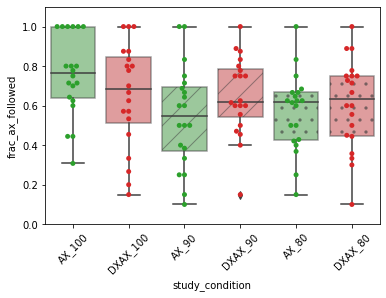

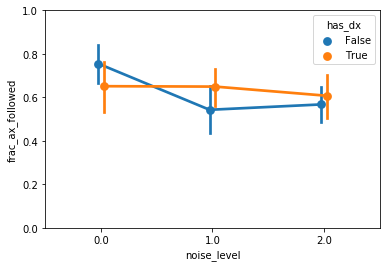

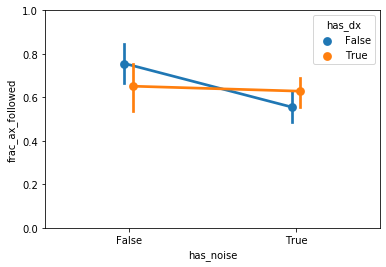



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
3                20  0.756039  0.207689  0.046441   0.662651  0.849428   
4                20  0.651676  0.264666  0.059181   0.532667  0.770684   
6                20  0.543130  0.255905  0.057222   0.428061  0.658198   
7                20  0.649804  0.199508  0.044611   0.560094  0.739513   
9                20  0.567818  0.196894  0.044027   0.479284  0.656353   
10               20  0.607713  0.227954  0.050972   0.505212  0.710213   

                   median  
study_condition            
3                0.763889  
4                0.683333  
6                0.550000  
7                0.620192  
9                0.620192  
10               0.633333  

                            OLS Regression Results                            
Dep. Variable:       frac_ax_followed   R-squared:                       0.089
Model:       

In [60]:
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df['has_ax'],:]
plot_conditions = [x for x in study_conditions if 'AX' in x.name]

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1.1],
    },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', 'ylim': [0, 1] },
    { 'var': ('has_noise', 'has_dx'), 'type': 'point', 'ylim': [0, 1] },
]
out_var = 'frac_ax_followed'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of number of actions that were deemed optimal for the state
o, r = stats.test_significance(plot_df,
                               'frac_ax_followed',
                               'study_condition',
#                                'has_dx', 'has_noise',
#                                'num_ax_corrupt',
                               correction_method='fdr_bh')
print(o)

### Decision Time

How long was the participant taking to make actions (or pick diagnoses)? Was this affected by the condition?

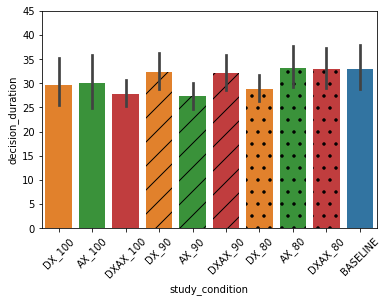

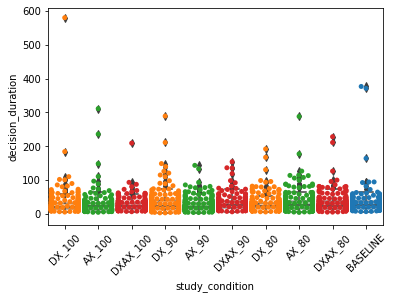

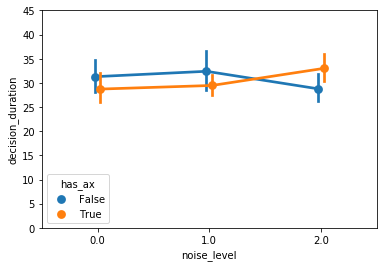

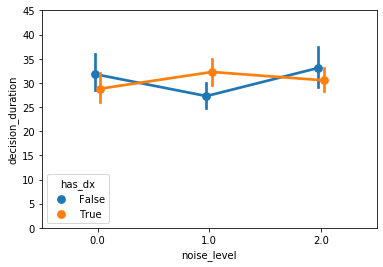

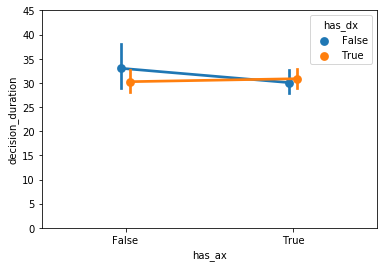



Summary:
                   N       Mean         SD        SE  95% Conf.   Interval  \
study_condition                                                              
1                231  33.024355  36.606146  2.408508  28.293429  37.755281   
2                247  29.672004  40.854654  2.599519  24.566601  34.777407   
3                152  30.001724  35.319051  2.864753  24.368245  35.635202   
4                193  27.730363  20.619156  1.484199  24.813766  30.646959   
5                243  32.408366  31.161271  1.998996  28.482246  36.334486   
6                217  27.279949  20.088766  1.363714  24.600889  29.959009   
7                183  32.085541  23.394837  1.729396  28.686625  35.484457   
8                256  28.785230  22.658246  1.416140  26.004158  31.566303   
9                204  33.094657  31.348349  2.194823  28.782220  37.407093   
10               189  32.917069  28.567561  2.077984  28.833402  37.000736   

                  median  
study_condition          

In [61]:
# The time from video start to action selection (including DX and certainty)
plot_df = data_loader.get_actions_df()
plot_conditions = study_conditions

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 45],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 45], },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', 'ylim': [0, 45], },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [0, 45], },
]
out_var = 'decision_duration'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of decision_duration ~ study_condition
o, r = stats.test_significance(plot_df,
                               'decision_duration',
                               'study_condition',
#                                'has_dx', 'has_ax', 'has_noise',
                               correction_method='fdr_bh')
print(o)

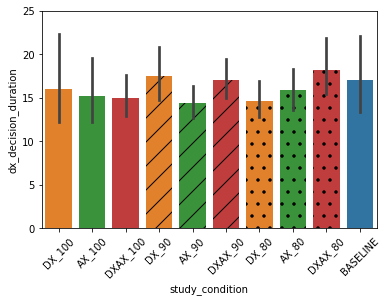

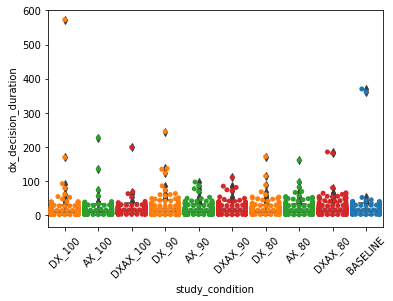

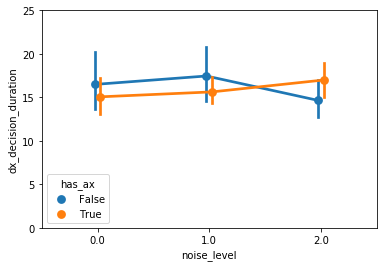

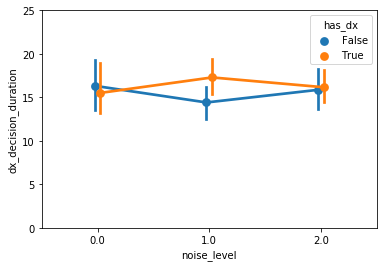

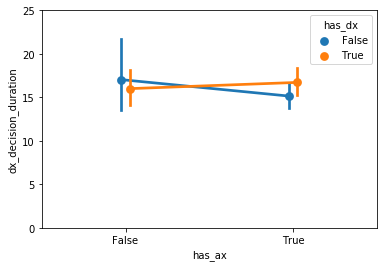



Summary:
                   N       Mean         SD        SE  95% Conf.   Interval  \
study_condition                                                              
1                231  17.045221  33.977420  2.235550  12.654027  21.436414   
2                247  15.984364  38.805810  2.469155  11.134995  20.833734   
3                152  15.248112  22.729836  1.843633  11.622645  18.873578   
4                193  14.930466  16.719948  1.203528  12.565416  17.295517   
5                243  17.465053  23.745818  1.523295  14.473233  20.456874   
6                217  14.422230  14.026283  0.952166  12.551670  16.292791   
7                183  17.077328  15.787525  1.167047  14.783639  19.371016   
8                256  14.659437  16.439202  1.027450  12.641691  16.677184   
9                204  15.874686  17.849499  1.249715  13.419219  18.330153   
10               189  18.219709  22.604695  1.644250  14.988420  21.450998   

                 median  
study_condition          


In [63]:
# The time to select a diagnosis
plot_df = data_loader.get_actions_df()
plot_conditions = study_conditions

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 25],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 25], },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', 'ylim': [0, 25], },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [0, 25], },
]
out_var = 'dx_decision_duration'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of decision_duration ~ study_condition
o, r = stats.test_significance(plot_df,
                               'dx_decision_duration',
                               'study_condition',
#                                'has_dx', 'has_ax', 'has_noise',
                               correction_method='fdr_bh')
print(o)

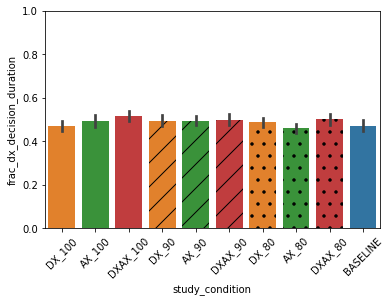

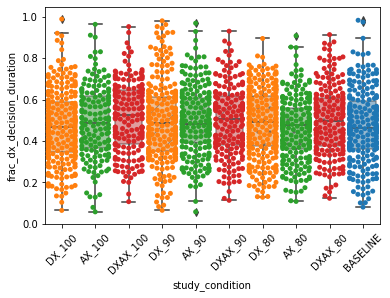

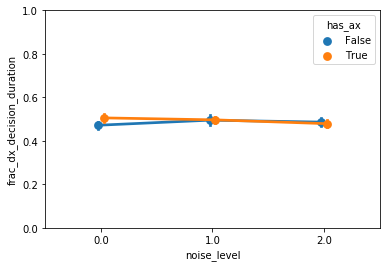

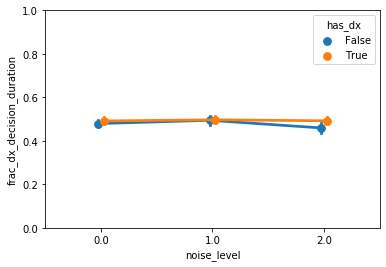

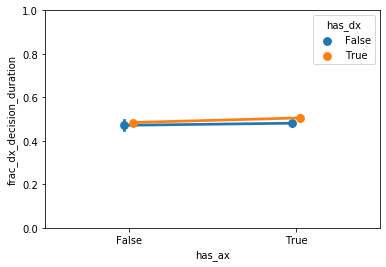



Summary:
                   N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                           
1                231  0.471881  0.176493  0.011612   0.449071  0.494690   
2                247  0.472232  0.172661  0.010986   0.450655  0.493808   
3                152  0.491650  0.175571  0.014241   0.463646  0.519654   
4                193  0.517140  0.165956  0.011946   0.493666  0.540615   
5                243  0.495346  0.189521  0.012158   0.471467  0.519224   
6                217  0.494725  0.161199  0.010943   0.473227  0.516223   
7                183  0.499381  0.167128  0.012354   0.475099  0.523662   
8                256  0.486628  0.163754  0.010235   0.466529  0.506727   
9                204  0.459737  0.153091  0.010718   0.438677  0.480797   
10               189  0.500479  0.168690  0.012270   0.476365  0.524593   

                   median  
study_condition            
1                0.462570  
2   

In [65]:
# The fraction of decision time spent selecting a diagnosis
plot_df = data_loader.get_actions_df()
plot_conditions = study_conditions

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 1], },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', 'ylim': [0, 1], },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [0, 1], },
]
out_var = 'frac_dx_decision_duration'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of decision_duration ~ study_condition
o, r = stats.test_significance(plot_df,
                               'frac_dx_decision_duration',
                               'study_condition',
#                                'has_dx', 'has_ax', 'has_noise',
                               correction_method='fdr_bh')
print(o)

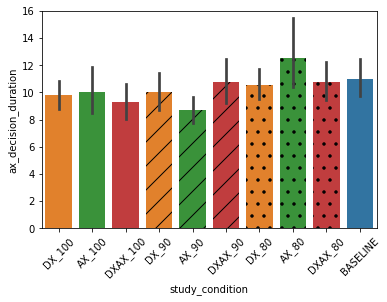

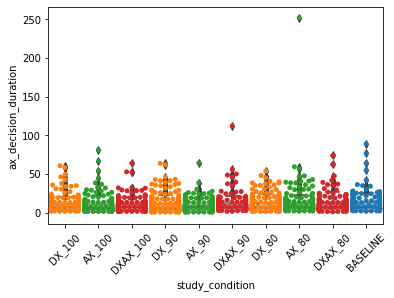

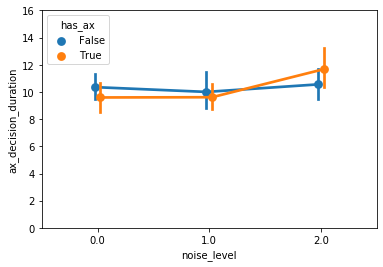

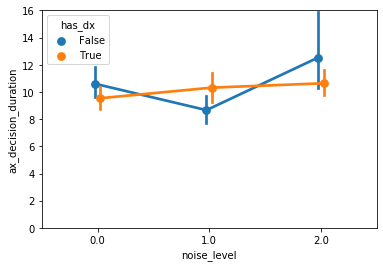

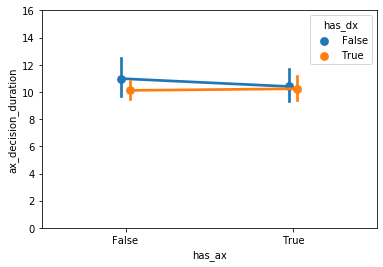



Summary:
                   N       Mean         SD        SE  95% Conf.   Interval  \
study_condition                                                              
1                231  10.985706  10.876506  0.715622   9.580041  12.391370   
2                247   9.769874   8.978827  0.571309   8.647835  10.891914   
3                152  10.033783  11.624528  0.942874   8.179641  11.887925   
4                193   9.254337   8.826871  0.635372   8.005769  10.502905   
5                243  10.006177  10.319766  0.662013   8.705953  11.306401   
6                217   8.665834   7.367779  0.500157   7.683259   9.648409   
7                183  10.741230  11.654887  0.861554   9.047951  12.434508   
8                256  10.559531   9.076123  0.567258   9.445528  11.673534   
9                204  12.531770  19.729227  1.381322   9.817718  15.245821   
10               189  10.752831  10.154653  0.738642   9.301247  12.204415   

                 median  
study_condition          


In [67]:
# The time to select a diagnosis
plot_df = data_loader.get_actions_df()
plot_conditions = study_conditions

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 16],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 16], },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', 'ylim': [0, 16], },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [0, 16], },
]
out_var = 'ax_decision_duration'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of decision_duration ~ study_condition
o, r = stats.test_significance(plot_df,
                               'ax_decision_duration',
                               'study_condition',
#                                'has_dx', 'has_ax', 'has_noise',
                               correction_method='fdr_bh')
print(o)

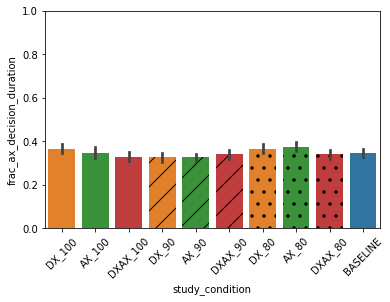

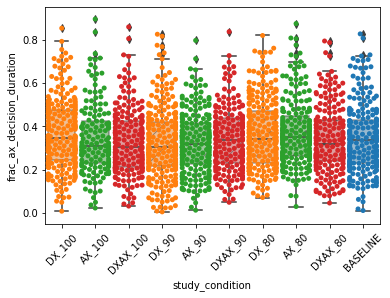

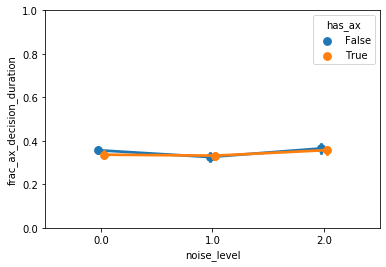

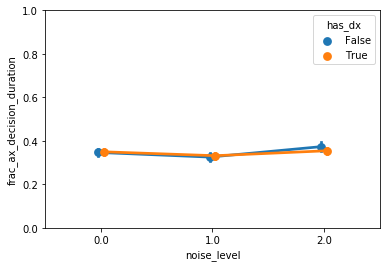

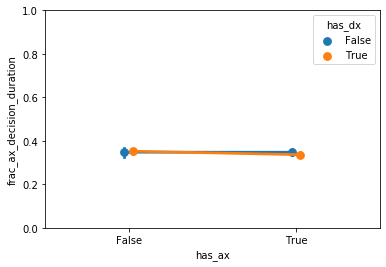



Summary:
                   N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                           
1                231  0.348168  0.156105  0.010271   0.327994  0.368343   
2                247  0.365690  0.158161  0.010064   0.345925  0.385454   
3                152  0.345372  0.164186  0.013317   0.319184  0.371560   
4                193  0.329870  0.152984  0.011012   0.308231  0.351510   
5                243  0.325840  0.163062  0.010460   0.305295  0.346385   
6                217  0.325701  0.141959  0.009637   0.306769  0.344633   
7                183  0.340263  0.148242  0.010958   0.318726  0.361801   
8                256  0.365585  0.157669  0.009854   0.346233  0.384938   
9                204  0.373671  0.153127  0.010721   0.352606  0.394736   
10               189  0.340032  0.155067  0.011279   0.317866  0.362199   

                   median  
study_condition            
1                0.334730  
2   

In [69]:
# The time to select a diagnosis
plot_df = data_loader.get_actions_df()
plot_conditions = study_conditions

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 1], },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', 'ylim': [0, 1], },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [0, 1], },
]
out_var = 'frac_ax_decision_duration'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of decision_duration ~ study_condition
o, r = stats.test_significance(plot_df,
                               'frac_ax_decision_duration',
                               'study_condition',
#                                'has_dx', 'has_ax', 'has_noise',
                               correction_method='fdr_bh')
print(o)

### Correct Diagnoses?

Was the participant identifying the correct diagnoses?

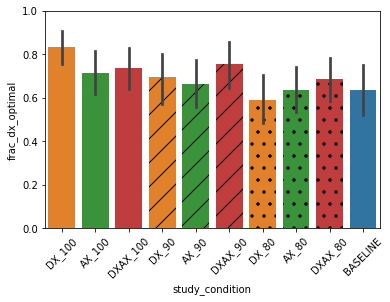

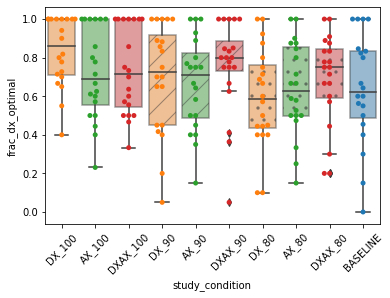

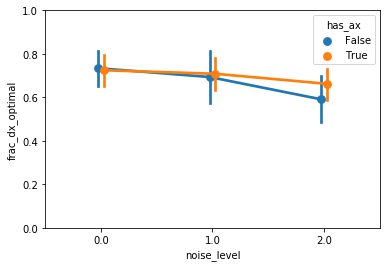

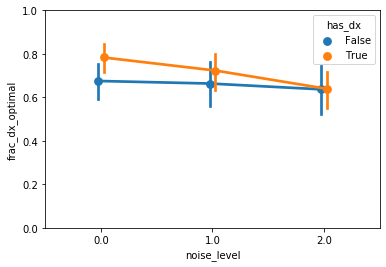

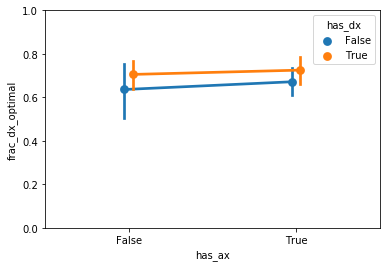



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
1                20  0.636479  0.285826  0.063913   0.507956  0.765002   
2                20  0.832268  0.179963  0.040241   0.751347  0.913189   
3                20  0.714931  0.237658  0.053142   0.608067  0.821795   
4                20  0.735191  0.228711  0.051141   0.632350  0.838032   
5                20  0.693919  0.284322  0.063576   0.566072  0.821766   
6                20  0.663977  0.242764  0.054284   0.554817  0.773137   
7                20  0.753717  0.243109  0.054361   0.644402  0.863032   
8                20  0.591342  0.260352  0.058216   0.474274  0.708411   
9                20  0.637214  0.241069  0.053905   0.528817  0.745612   
10               20  0.687935  0.239960  0.053657   0.580036  0.795834   

                   median  
study_condition            
1                0.621429  
2               

In [70]:
# The number of times the correct diagnosis was selected (all conditions)
plot_df = data_loader.get_users_df()
plot_conditions = study_conditions

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 1] },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', 'ylim': [0, 1] },
    { 'var': ('has_ax', 'has_dx'), 'type': 'point', 'ylim': [0, 1] },
]
out_var = 'frac_dx_optimal'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of number of actions that were deemed optimal for the state
o, r = stats.test_significance(plot_df,
                               'frac_dx_optimal',
                               'study_condition',
#                                'has_dx', 'has_noise',
                               correction_method='fdr_bh')
print(o)

# Box-Cox transformation does not seem to affect this result

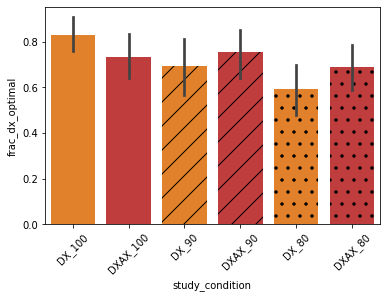

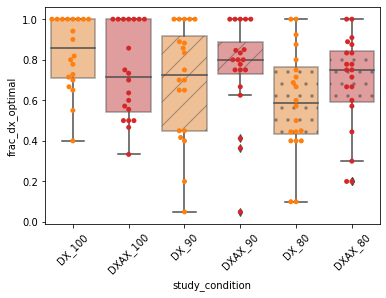

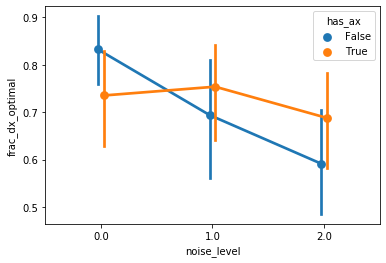

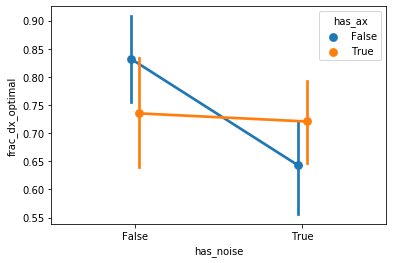



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
2                20  0.832268  0.179963  0.040241   0.751347  0.913189   
4                20  0.735191  0.228711  0.051141   0.632350  0.838032   
5                20  0.693919  0.284322  0.063576   0.566072  0.821766   
7                20  0.753717  0.243109  0.054361   0.644402  0.863032   
8                20  0.591342  0.260352  0.058216   0.474274  0.708411   
10               20  0.687935  0.239960  0.053657   0.580036  0.795834   

                   median  
study_condition            
2                0.859091  
4                0.716667  
5                0.725000  
7                0.800000  
8                0.585714  
10               0.750000  

                            OLS Regression Results                            
Dep. Variable:        frac_dx_optimal   R-squared:                       0.088
Model:       

In [73]:
# The number of times the correct diagnosis was selected (when suggestions were provided)
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df['has_dx'],:]
plot_conditions = [x for x in study_conditions if 'DX' in x.name]

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', },
    { 'var': ('has_noise', 'has_ax'), 'type': 'point', },
]
out_var = 'frac_dx_optimal'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of number of actions that were deemed optimal for the state
o, r = stats.test_significance(plot_df,
                               'frac_dx_optimal',
                               'study_condition',
#                                'has_dx', 'noise_level',
#                                'has_dx', 'has_noise',
                               correction_method='fdr_bh')
print(o)

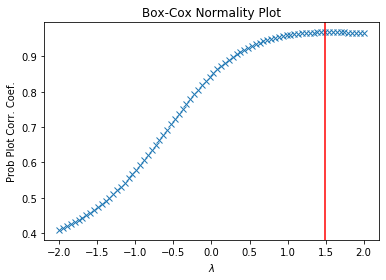

Transformed Y: 1.4856077570833932, (1.106697135207329, 1.9158416231670772)


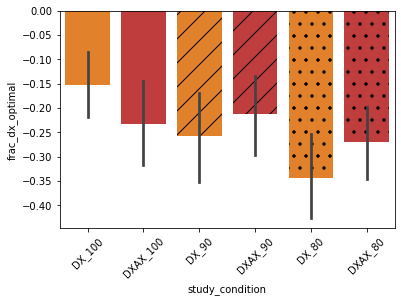

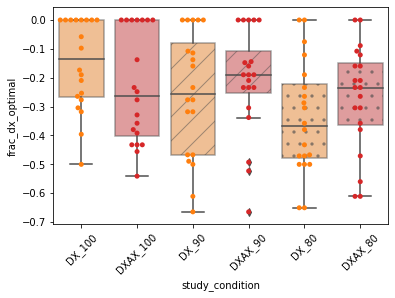

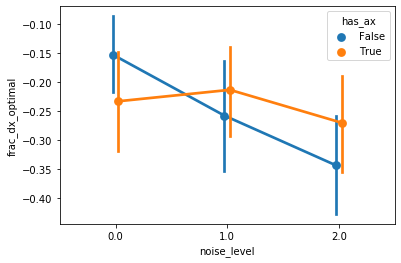

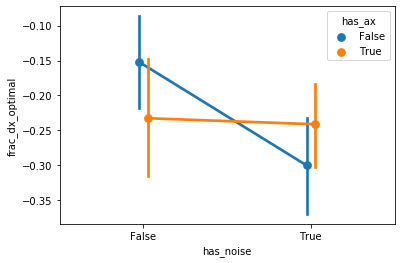



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
2                20 -0.152180  0.157709  0.035265  -0.223095 -0.081266   
4                20 -0.232621  0.195707  0.043761  -0.320621 -0.144620   
5                20 -0.257314  0.217626  0.048663  -0.355170 -0.159457   
7                20 -0.212916  0.184235  0.041196  -0.295758 -0.130074   
8                20 -0.343115  0.195282  0.043666  -0.430925 -0.255306   
10               20 -0.269602  0.183770  0.041092  -0.352235 -0.186968   

                   median  
study_condition            
2               -0.135525  
4               -0.262695  
5               -0.255488  
7               -0.189927  
8               -0.368994  
10              -0.234104  

                            OLS Regression Results                            
Dep. Variable:        frac_dx_optimal   R-squared:                       0.089
Model:       

In [78]:
# The number of times the correct diagnosis was selected (when suggestions were provided)
# Use a boxcox transformation this time
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df['has_dx'],:]
plot_conditions = [x for x in study_conditions if 'DX' in x.name]

# Run a box-cox transform
x = plot_df['frac_dx_optimal'].to_numpy()+1e-7
fig = plt.figure()
ax = fig.add_subplot(111)
spstats.boxcox_normplot(x, -2, 2, plot=ax)
lmbda = None
if lmbda is None:
    (y, lmbda, ci) = spstats.boxcox(x, alpha=0.05)
else:
    y = spstats.boxcox(x, lmbda=lmbda)
    ci = None
ax.axvline(lmbda, color='r')
plt.show()
print(f'Transformed Y: {lmbda}, {ci}')

plot_df['frac_dx_optimal'] = y
variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', },
    { 'var': ('has_noise', 'has_ax'), 'type': 'point', },
]
out_var = 'frac_dx_optimal'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of number of actions that were deemed optimal for the state
o, r = stats.test_significance(plot_df,
                               'frac_dx_optimal',
                               'study_condition',
#                                'has_dx', 'noise_level',
#                                'has_dx', 'has_noise',
                               correction_method='fdr_bh')
print(o)

### Diagnosis Suggestions Followed

Did people follow suggestions when they were present? What if they were corrupted?

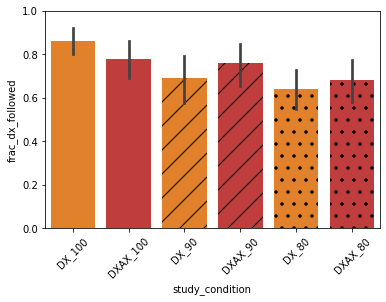

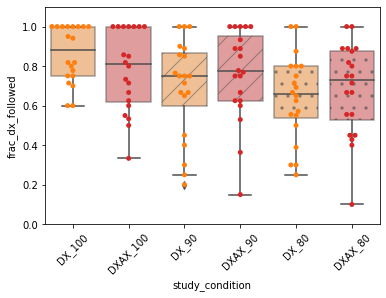

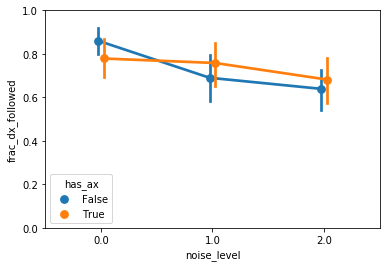

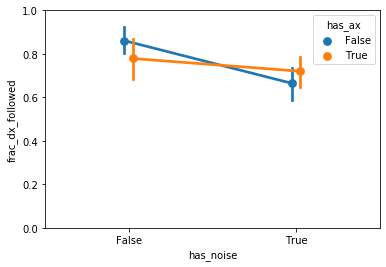



Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                          
2                20  0.860980  0.143557  0.032100   0.796429  0.925531   
4                20  0.779064  0.207607  0.046422   0.685712  0.872415   
5                20  0.690418  0.248432  0.055551   0.578709  0.802126   
7                20  0.758392  0.230908  0.051633   0.654563  0.862221   
8                20  0.639457  0.217461  0.048626   0.541674  0.737239   
10               20  0.682358  0.233197  0.052144   0.577500  0.787215   

                   median  
study_condition            
2                0.879679  
4                0.809091  
5                0.750000  
7                0.773504  
8                0.658333  
10               0.732143  

                            OLS Regression Results                            
Dep. Variable:       frac_dx_followed   R-squared:                       0.108
Model:       

In [80]:
plot_df = data_loader.get_users_df()
plot_df = plot_df.loc[plot_df['has_dx'],:]
plot_conditions = [x for x in study_conditions if 'DX' in x.name]

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [0, 1.1],
    },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [0, 1] },
    { 'var': ('has_noise', 'has_ax'), 'type': 'point', 'ylim': [0, 1] },
]
out_var = 'frac_dx_followed'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of number of actions that were deemed optimal for the state
o, r = stats.test_significance(plot_df,
                               'frac_dx_followed',
                               'study_condition',
#                                'has_dx', 'has_noise',
#                                'num_ax_corrupt',
                               correction_method='fdr_bh')
print(o)

### Certainty

Is this correlated with whether the participant was following suggestions? What if the suggestions were corrupted?

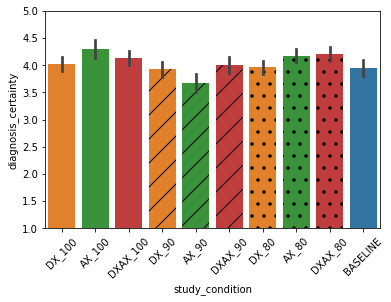

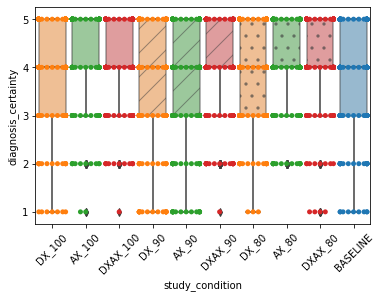

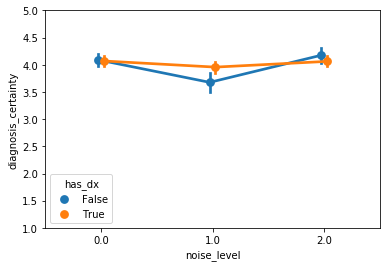

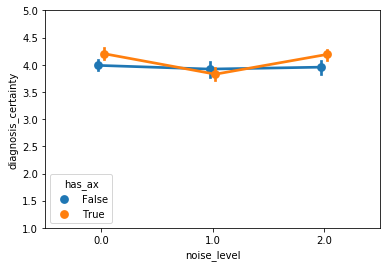

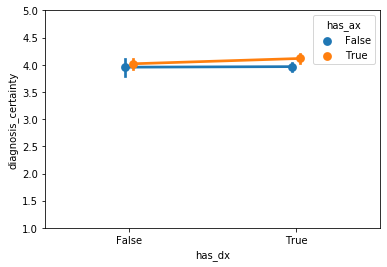



Summary:
                   N      Mean        SD        SE  95% Conf.  Interval  \
study_condition                                                           
1                231  3.956710  1.129769  0.074333   3.810700  4.102720   
2                247  4.020243  1.060945  0.067506   3.887662  4.152824   
3                152  4.296053  0.995612  0.080755   4.137250  4.454855   
4                193  4.134715  0.919968  0.066221   4.004585  4.264845   
5                243  3.921811  1.184463  0.075983   3.772576  4.071045   
6                217  3.677419  1.264580  0.085845   3.508774  3.846065   
7                183  4.005464  0.991709  0.073309   3.861384  4.149545   
8                256  3.957031  0.967161  0.060448   3.838322  4.075741   
9                204  4.176471  0.951139  0.066593   4.045627  4.307314   
10               189  4.206349  0.942361  0.068547   4.071641  4.341058   

                 median  
study_condition          
1                     4  
2         

In [82]:
# Get a certainty plot
plot_df = data_loader.get_actions_df()
plot_conditions = study_conditions

variables_to_plot = [
    {
        'var': ('study_condition',),
        'type': 'bar',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
        'ylim': [1, 5],
    },
    {
        'var': ('study_condition',),
        'type': 'box',
        'order': plot_conditions,
        'labels': [x.name for x in plot_conditions],
        'palette': study_conditions_colour_dict,
        'hatches': study_conditions_hatches_dict,
        'rotation': 45,
    },
    { 'var': ('noise_level', 'has_dx'), 'type': 'point', 'ylim': [1, 5], },
    { 'var': ('noise_level', 'has_ax'), 'type': 'point', 'ylim': [1, 5], },
    { 'var': ('has_dx', 'has_ax'), 'type': 'point', 'ylim': [1, 5], },
]
out_var = 'diagnosis_certainty'

plotter.plot_data(plot_df, variables_to_plot, out_var)

# Check the significance of certainty ~ study_condition
o, r = stats.test_significance(plot_df,
                               'diagnosis_certainty',
                               'study_condition',
#                                'has_dx', 'has_ax', 'has_noise',
                               correction_method='fdr_bh')
print(o)

## The Domain

Were there idiosyncracies in the domain that might've led to the results we see

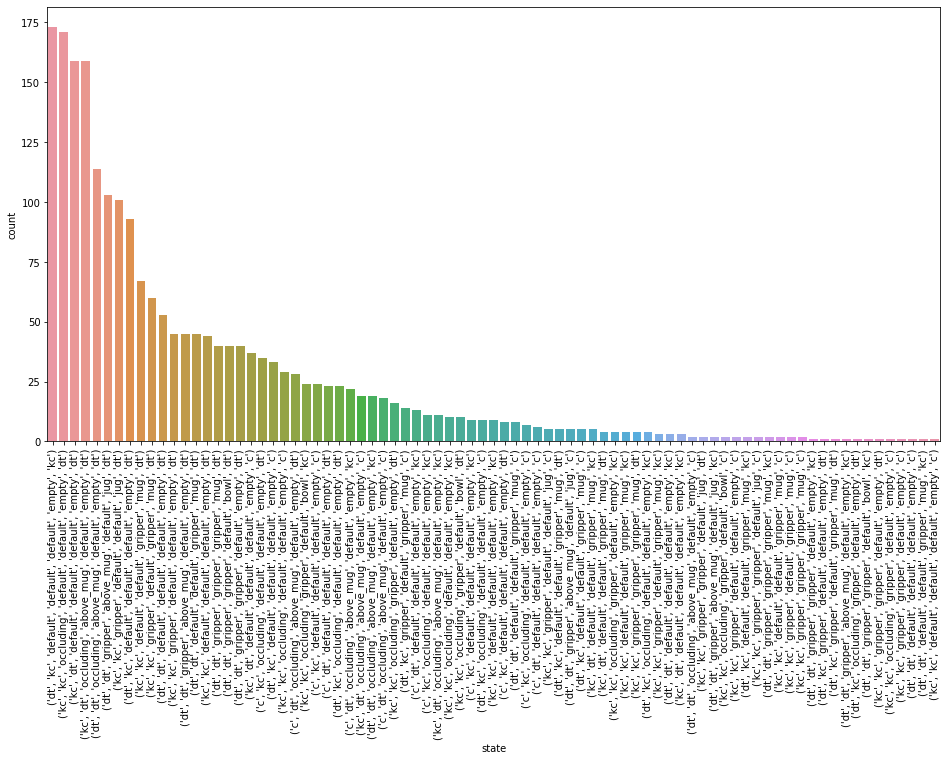

In [71]:
# Histogram of the different states
plot_df = states_df.copy()
fig = plt.figure(figsize=(16, 8))
ax = sns.countplot(x='state', data=plot_df, order=plot_df['state'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

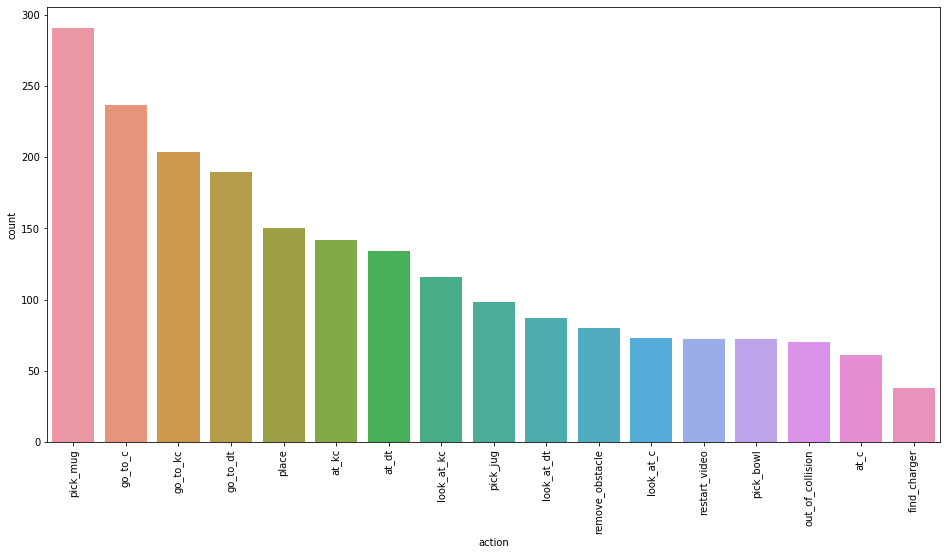

In [72]:
# Histogram of the different actions
plot_df = states_df.copy()
fig = plt.figure(figsize=(16, 8))
ax = sns.countplot(x='action', data=plot_df, order=plot_df['action'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

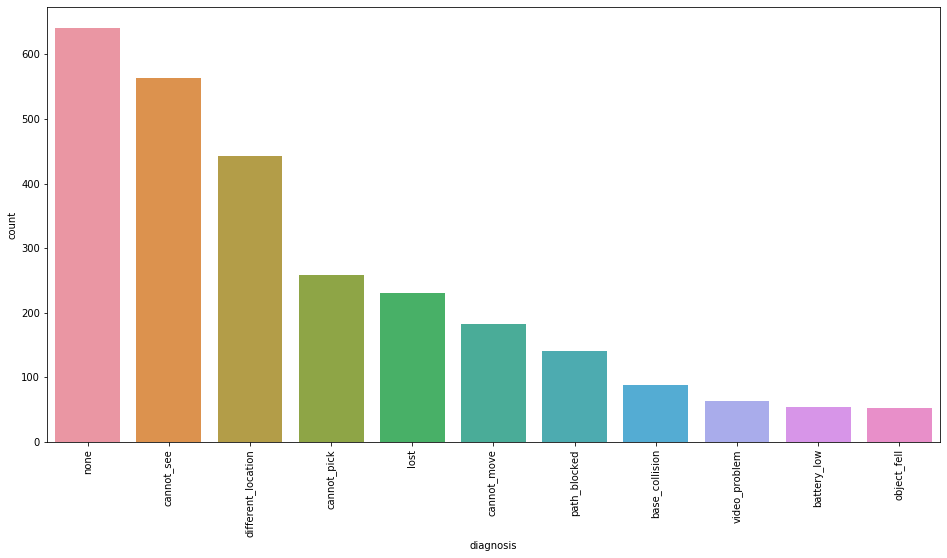

In [94]:
# Histogram of the different diagnoses
plot_df = states_df.copy()
plot_df['id'] = plot_df.index
plot_df = plot_df.melt(
    id_vars=['id', 'study_condition', 'has_ax', 'noise_level', 'has_dx'],
    value_vars=[
        f'{diagnosis}_selected'
        for diagnosis in constants.DIAGNOSES.keys()
    ],
    var_name='diagnosis'
)
plot_df['diagnosis'] = plot_df['diagnosis'].apply(lambda x: x[:-9])
fig = plt.figure(figsize=(16, 8))
ax = sns.countplot(x='diagnosis', data=plot_df.loc[plot_df['value'], :],
                   order=plot_df.loc[plot_df['value'], 'diagnosis'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

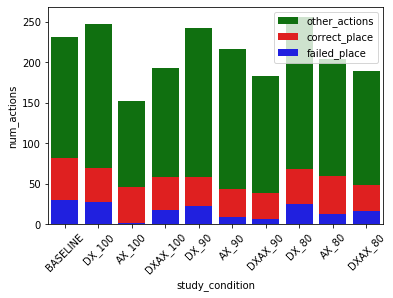

In [80]:
# Counts of the number of failed-to-place actions per condition
plot_df = states_df.copy()
# fig = plt.figure(figsize=(16, 8))
ax = sns.countplot(
    x='study_condition',
    data=plot_df,
    color='green',
    order=study_conditions
)
ax = sns.countplot(
    x='study_condition',
    data=plot_df.loc[~plot_df['failed_to_place'].isna(), :],
    color='red',
    order=study_conditions
)
ax = sns.countplot(
    x='study_condition',
    data=plot_df.loc[~plot_df['failed_to_place'].isna() & plot_df['failed_to_place'], :],
    color='blue',
    order=study_conditions
)
ax.set_xticklabels([x.name for x in study_conditions])
ax.set_ylabel('num_actions')
ax.legend(labels=['other_actions', 'correct_place', 'failed_place'])
plt.xticks(rotation=45)
plt.show()

In [75]:
# Check the significance of failed_to_place ~ study_condition
plot_df = plot_df = states_df.loc[~states_df['failed_to_place'].isna(), :].copy()
plot_df['failed_to_place'] = plot_df['failed_to_place'].astype(np.int)
plot_df['has_dx'] = plot_df['has_dx'].astype(np.int)
plot_df['has_ax'] = plot_df['has_ax'].astype(np.int)
plot_df['has_noise'] = plot_df['has_noise'].astype(np.int)

o, r = stats.test_significance(plot_df, 'failed_to_place', 'study_condition',
                               logit_model=True, correction_method='bonf')
# o, r = stats.test_significance(plot_df, 'failed_to_place', 'has_noise', 'has_ax', 'has_dx',
#                                logit_model=True, correction_method='bonf')
print(o)



Optimization terminated successfully.
         Current function value: 0.567293
         Iterations 8
Summary:
                  N      Mean        SD        SE  95% Conf.  Interval  median
study_condition                                                               
1                82  0.365854  0.484633  0.053519   0.260311  0.471396       0
2                69  0.391304  0.491618  0.059184   0.274454  0.508154       0
3                46  0.021739  0.147442  0.021739  -0.021340  0.064819       0
4                58  0.293103  0.459161  0.060291   0.173901  0.412305       0
5                59  0.389831  0.491898  0.064040   0.263235  0.516426       0
6                44  0.204545  0.408032  0.061513   0.082586  0.326505       0
7                39  0.153846  0.365518  0.058530   0.037628  0.270064       0
8                68  0.367647  0.485750  0.058906   0.251333  0.483961       0
9                60  0.216667  0.415450  0.053634   0.110656  0.322677       0
10               4

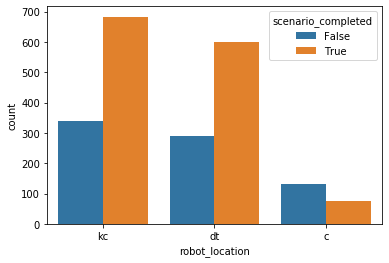

In [76]:
plot_df = states_df.copy()
ax = sns.countplot(x='robot_location', hue='scenario_completed', data=plot_df)
plt.show()

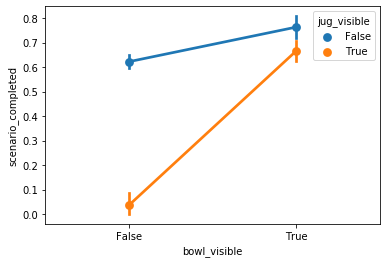

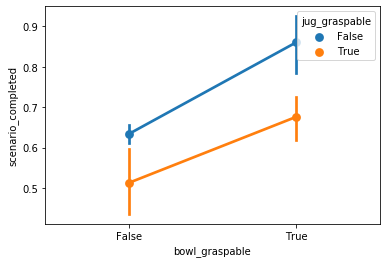

In [77]:
plot_df = states_df.copy()
plot_df['scenario_completed'] = plot_df['scenario_completed'].astype(np.int)
variables_to_plot = [
    {
        'var': ('bowl_visible', 'jug_visible'),
        'type': 'point',
    },
    {
        'var': ('bowl_graspable', 'jug_graspable'),
        'type': 'point',
    },
]
out_var = 'scenario_completed'

plot_data(plot_df, variables_to_plot, out_var)

In [78]:
# Check the time of day isn't messing with our results
plot_df = user_actions_df.copy()
plot_df['tod'] = plot_df['date_demographics_completed']\
                    .apply(lambda x: timezone.localtime(x, pytz.timezone('America/New_York')))\
                    .apply(lambda x: ('morn' if 6 <= x.hour <= 10
                                      else ('noon' if 11 <= x.hour <= 15
                                            else 'evening' if 16 <= x.hour <= 20 else 'night')))
plot_df['num_actions_diff'] = plot_df['num_actions'] - plot_df['num_optimal']

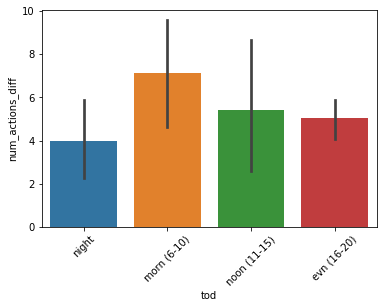

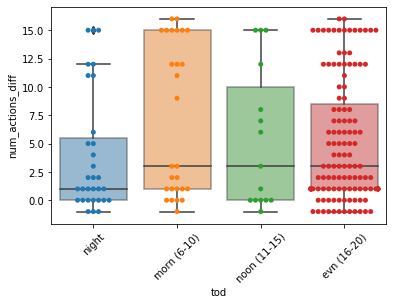

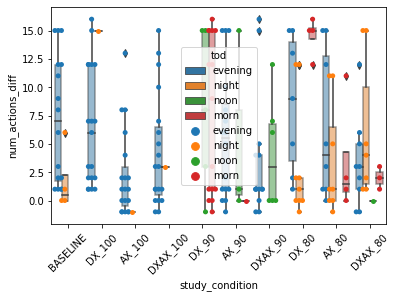

In [79]:
variables_to_plot = [
    {
        'var': ('tod',),
        'type': 'bar',
        'order': ['night', 'morn', 'noon', 'evening'],
        'labels': ['night', 'morn (6-10)', 'noon (11-15)', 'evn (16-20)'],
        'rotation': 45,
    },
    {
        'var': ('tod',),
        'type': 'box',
        'order': ['night', 'morn', 'noon', 'evening'],
        'labels': ['night', 'morn (6-10)', 'noon (11-15)', 'evn (16-20)'],
        'rotation': 45,
    },
    {
        'var': ('study_condition', 'tod'),
        'type': 'box',
        'order': study_conditions,
        'labels': [x.name for x in study_conditions],
        'rotation': 45,
    },
]
out_var = 'num_actions_diff'

plot_data(plot_df, variables_to_plot, out_var, as_subplots=False)